<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

_Authors:_ Joseph Nelson (DC), Boom Devahastin Na Ayudhya (NYC), Bethany Poulin (Boston)

---

## Introduction


The most common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. Your supervisor has set out the following goals for this project:

1. Record any observed trends in the data.
2. Produce a trained model to predict future sales numbers.
3. Include useful AND COMMENT ON how graphs (ACF, PACF) impact your modelling decisions throughout your notebook.

Try your best to tune your model. It can be difficult, but don't worry - time series analysis is a difficult and specialized topic.

## Exercise
---

#### Requirements

- Assemble observations and graphs as well as time series models in a notebook.


#### Additional Resources

1. [ARMA Example](https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html)
2. [ARMA Models for TSA](https://www.quantstart.com/articles/Autoregressive-Moving-Average-ARMA-p-q-Models-for-Time-Series-Analysis-Part-1)

#### Things to Consider

You should always be looking for ways to reduce redundancy in your code, improve consistency in your output, and make it easier for others to follow your work! Functions are a huge part of this endeavor!

While working on this lab, you may try a number of $p$, $q$, and $d$ values to best account for your data. Because you will likely be repeating yourself, it is useful to create functions that declutter your workspace.

 - You may want to create a wrapper around the Augmented Dickey-Fuller test to provide both results and context for the output.
 - You may find value in a combined ACF & PACF function.
 - You may find it cleaner to build a function to make residual graphs and print out MSE all at once.

### Importing Necessary Libraries & Loading Data

In [1]:
# Importing libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import ADFTest
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller  
import pmdarima as pm
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

## Exploratory Analysis

#### 0. Preprocessing Data
It's always a good idea to evaluate the current state of your data. For every set of data this means something different. But the bare minimum is understanding what types of data you have, knowing if there are missing values and checking to be sure that your date column (or index) is in a proper date format.

Accordingly you should check:
 - Format of date column/index
 - Data types for each column
 - Whether or not we will have to deal with missing data

In [2]:
# Read data
data = pd.read_csv('./datasets/train.csv')

In [3]:
# Check info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [4]:
# 1: Convert 'date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# 2: Set index to be the date column 
data = data.set_index('Date')

# 3: ascending sort on the index: 'date' from earliest to latest
data = data.sort_index()

# Confirm.
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.500,False
2010-02-05,29,5,15552.080,False
2010-02-05,29,6,3200.220,False
2010-02-05,29,7,10820.050,False
2010-02-05,29,8,20055.640,False


In [5]:
# Check for missing values
data.isna().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [6]:
# Check data types
data.dtypes

Store             int64
Dept              int64
Weekly_Sales    float64
IsHoliday          bool
dtype: object

#### 1. Extracting Data to Model

Our data set has a number of stores, each with weekly sales volumes for many departments. 

To facilitate our first time series model, we need to use a single store, and aggregate the total sales for all departments.

**Aggregate all of the sales for STORE 1 into a new dataframe called `Weekly_Sales`.**

In [7]:
# Create mask for "Store 1" and apply to data
mask = data['Store'] == 1
data = data[mask]

# Create dataframe called `Weekly_Sales`.
Weekly_Sales = pd.DataFrame(data['Weekly_Sales'].groupby(data.index).sum())

In [8]:
# Check to make sure we did this properly
Weekly_Sales.head()

,Weekly_Sales
Date,
2010-02-05,1643690.900
2010-02-12,1641957.440
2010-02-19,1611968.170
2010-02-26,1409727.590
2010-03-05,1554806.680


#### 2. Plotting & Interpreting Time Series

Plots are a central part of all time series analysis. You should always start with a basic line plot.

**2a. Generate a line plot for `Weekly_Sales` with time on the $x$-axis.**

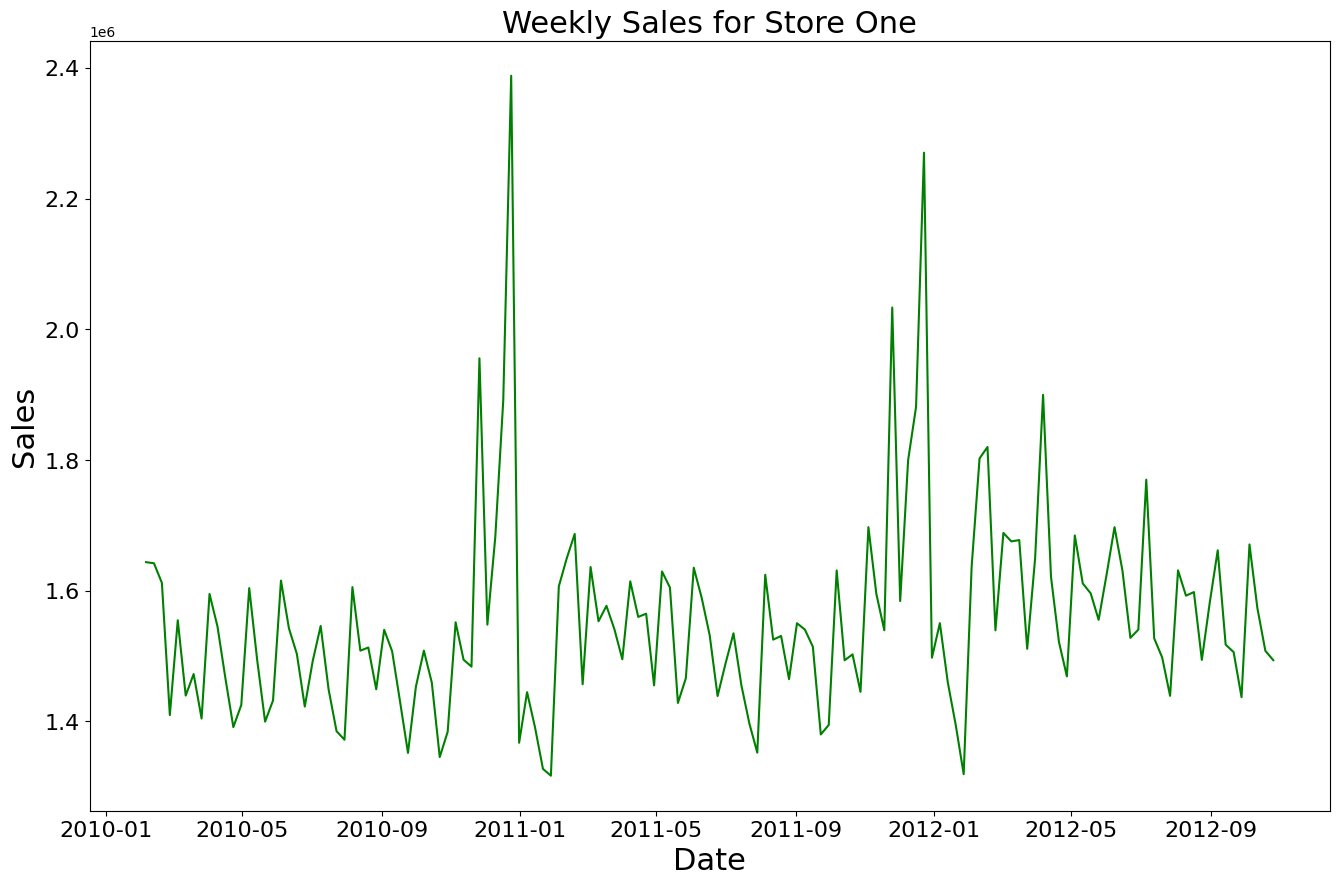

In [9]:
# Set figure size.
plt.figure(figsize=(16,10))

# Create line plot.
plt.plot(Weekly_Sales, c ='green')

# Set labels and title.
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Date', fontsize=22)
plt.ylabel('Sales', fontsize=22)
plt.title('Weekly Sales for Store One', fontsize=22);

Smoothing can help us see trends in the data. With time series, this frequently means plotting a rolling mean.

You might start looking at a one week roll, but you consider several 'windows' of time. 
 - What would a four week rolling mean look like? 
 - How about quarterly? 
 - Or annually? 

**2b. Calculate the rolling mean(s) for `Weekly_Sales` then plot them on a single set of axes.**

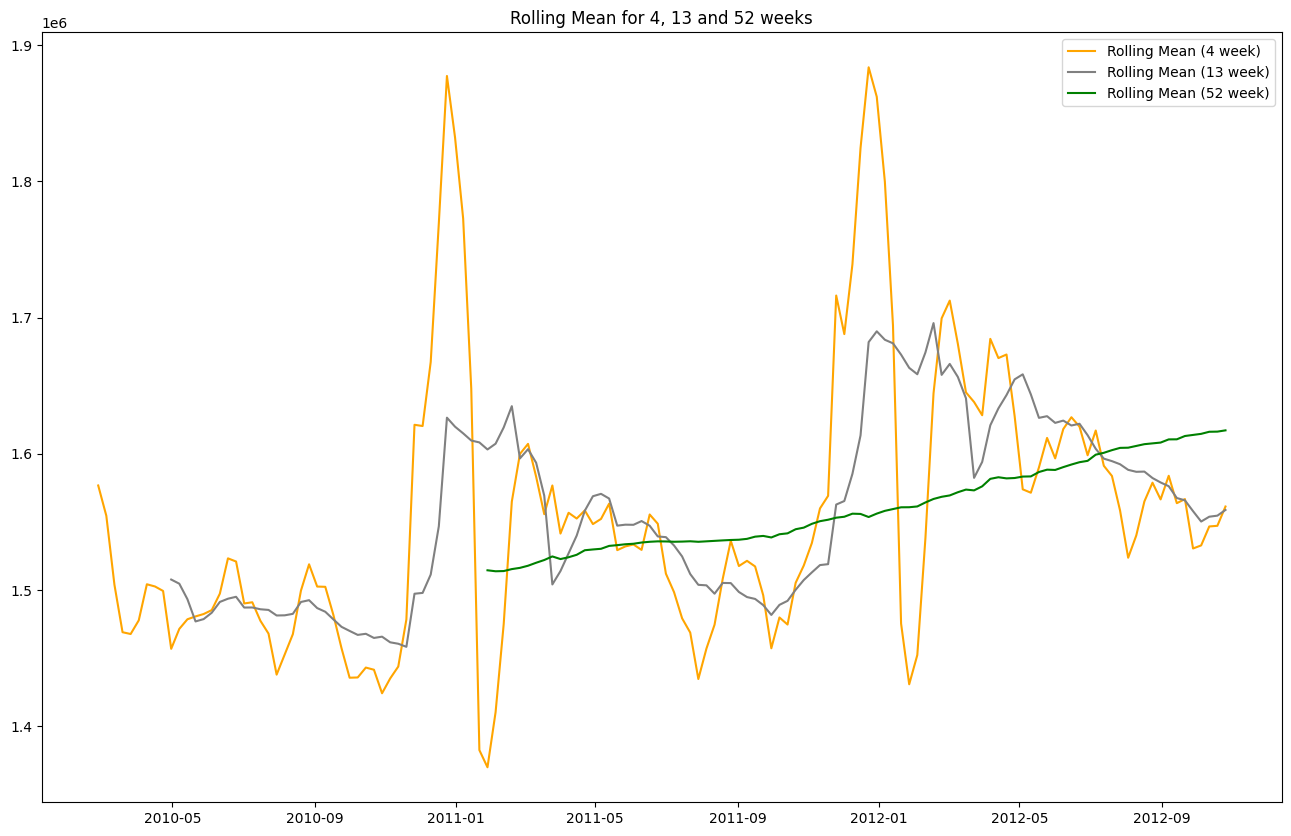

In [10]:
# Set a rolling mean with windows of 4, 13 and 52, I took out rolling mean of 1

# rolmean1  = Weekly_Sales.rolling(window = 1).mean()
rolmean4  = Weekly_Sales.rolling(window = 4).mean()
rolmean13 = Weekly_Sales.rolling(window = 13).mean()
rolmean52 = Weekly_Sales.rolling(window = 52).mean()

plt.figure(figsize=(16,10))

# plt.plot(rolmean1, color='blue', label='Rolling Mean (1 week)')

# Create our plots
plt.plot(rolmean4, color='orange', label='Rolling Mean (4 week)')
plt.plot(rolmean13, color='grey', label='Rolling Mean (13 week)')
plt.plot(rolmean52, color='green', label='Rolling Mean (52 week)')

plt.legend(loc='best')
plt.title('Rolling Mean for 4, 13 and 52 weeks')
plt.show();

**2c. What can you say about trends in the data based on the rolling mean plot above?**

**Answer:** *(Answers may vary.)* 
- There are clearly spikes in the early year around January. This is most likely the result of huge increases for holiday spending in November and December
- These spikes are followed, indicating a significant decrease in spending immediately following the holiday season, before sales start to pick up again
- We plot moving averages of 4, 13 and 52 weeks
    - 4 weeks is approximately one month
    - 13 weeks is approximately one quarter
    - 52 weeks is approximately one year

#### 3. Autocorrelations

We've learned about autocorrelation: the influence a serial observation has on the observations which follow.

Calculate autocorrelation in your `Weekly_Sales` data so that you can answer the question: 'How does autocorrelation differ as lag-weeks vary?'

**3a. Check at least three lag intervals (but feel free to explore others):**
 - **1 week**
 - **2 weeks**
 - **1 year (52 weeks)**

In [11]:
# Calculate autocorrelation for our lagged data
print(f'Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=1),4)}')
print(f'Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=2),4)}')
print(f'Autocorrelation between Weekly Sales and 3-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=3),4)}')
print(f'Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: {round(Weekly_Sales["Weekly_Sales"].autocorr(lag=52),4)}')

Autocorrelation between Weekly Sales and 1-lag Weekly_Sales: 0.3022
Autocorrelation between Weekly Sales and 2-lag Weekly_Sales: 0.1274
Autocorrelation between Weekly Sales and 3-lag Weekly_Sales: 0.0598
Autocorrelation between Weekly Sales and 52-lag Weekly_Sales: 0.8954


**3b. What can you say about the series based on these autocorrelations?**

**Answer:** *(Answers may vary.)*
- The single week autocorrelation shows that there is a fair amount of influence on sales each week from the prior week
- Looking at week two, it seems that the further away from the current week we look back, the less influence that week's sales have on the current week's sales. We can see this holds true since the autocorrelation value for a lag of 2 weeks shows even less correlated with the current week's sales than for a lag of 2 weeks
- The 52-week lag of sales is strongly correlated with the current week's sales. This would suggest that there might be a seasonal influence on sales separated by one year

**3c. Plotting ACF and PCF**
As we learned in lecture, plotting the `Autocorrelation Function` and `Partial Autocorrelation Functions` can be useful in understanding seasonality in time series data.

* Before you can plot an `ACF` and a `PACF` plot, ensure your data is stationary first.
* After doing so, make a 52-week `ACF` and 52-week `PACF` plot.

In [12]:
# Perform ADF test at 0.05 level of significance
adftest = ADFTest()
adftest.should_diff(Weekly_Sales)

(0.01, False)

**Comments**<br>
* p = 0.01
* p < 0.05
    * As such, we reject null hypothesis that the data is non-stationary.
    * We will treat the data as stationary.

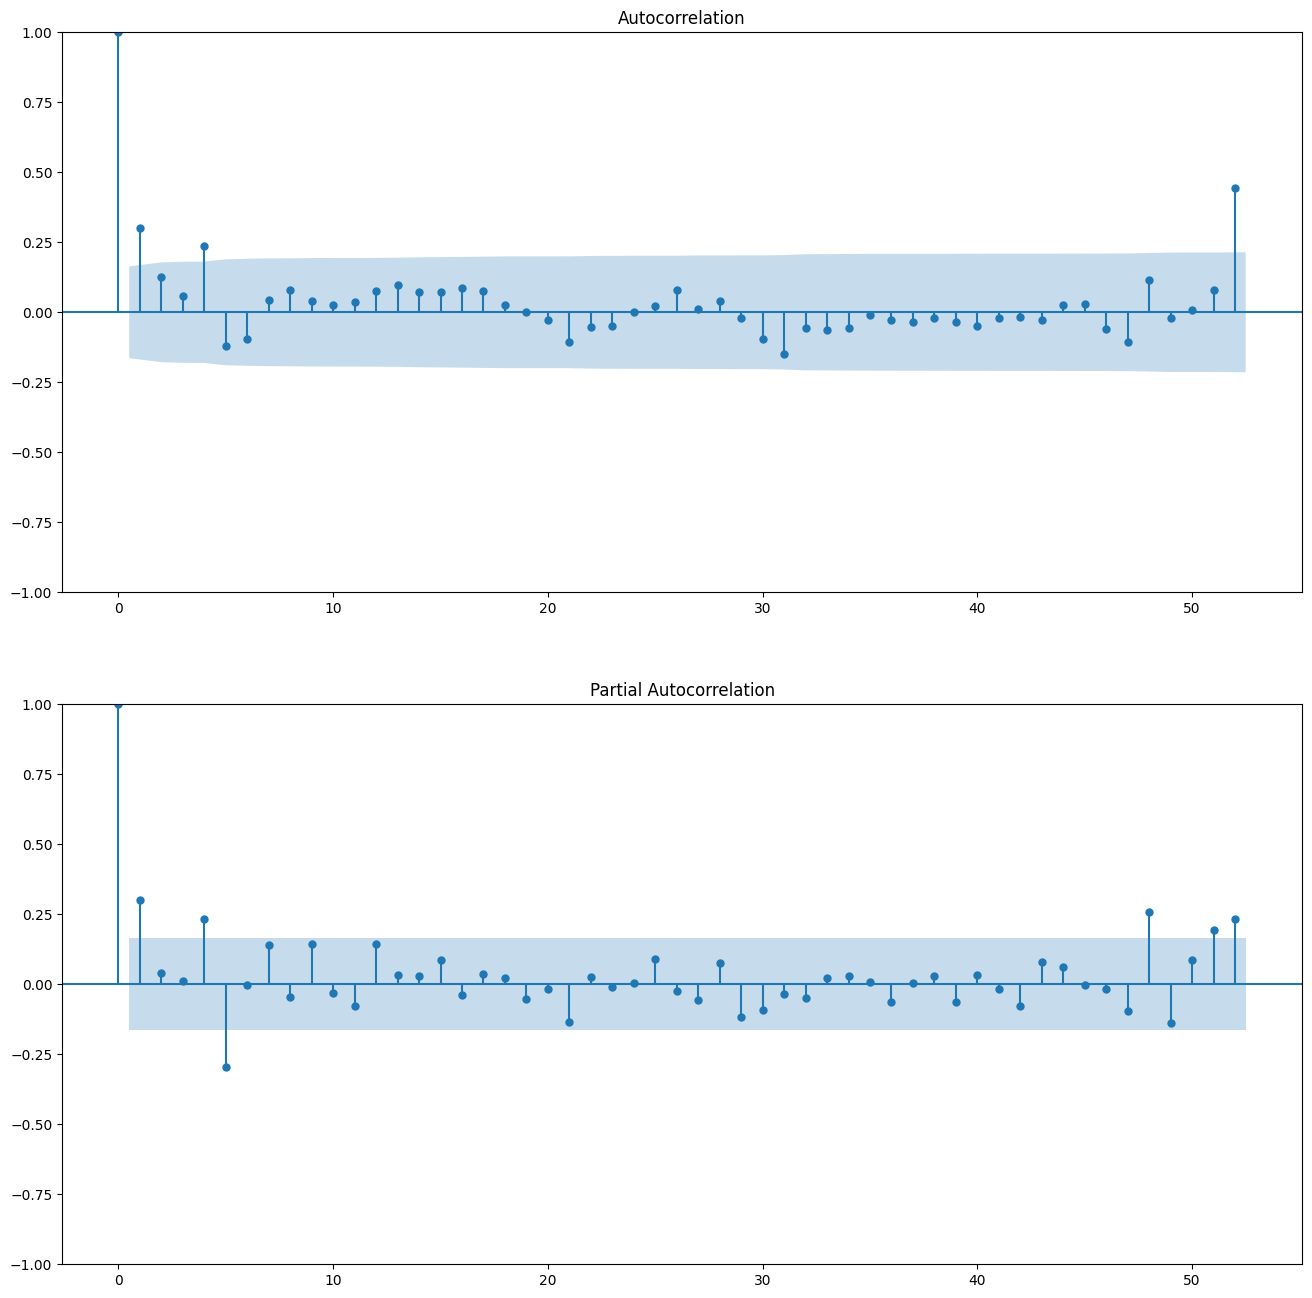

In [13]:
# Plot 52-week Autocorrelation and Partial Autocorrelation
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales, lags=52, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(Weekly_Sales, lags=52, ax=ax2);
plt.show();

#### 4. Interpreting the `ACF` and `PACF` Plots

**4a. What do the ACF and PACF graphs tell you about your sales data?**

**Answer:**

The filled blue space is representative of a 95% confidence interval. The points inside the blue space are likely to be noise, not any valuable correlation. Points outside the interval should be considered for further investigation.

The first point is meaningless: it represents the correlation between the `Weekly_Sales` and itself, so the correlation here should always be 1.

- At lag = 1, there is some relationship between the sales and prior day sales evidenced by both the ACF and PACF
- At lag = 4, there seems to be a correlation in both the ACF and PACF, this might be due to a monthly sales promotion or some kind of monthly cycle in sales
- At lag = 5 there is an interesting negative relationship which we cannot immediately infer about in the PACF (direct with no in-between relationships)
- At lag = 48, 50, 51, and 52 there is significant positive relationship in the PACF, possibly a correlation to monthly sales, within the seasonality of a year
- At lag = 52, there is a clear correlation in both the ACF and PACF. This should give us a sense that there might be a seasonal component in the series

**4b. How do the `ACF` and `PACF` inform your model selections moving forward?**

**Answer:** *(Answers may vary.)* 

We recognize that there is some correlation at 1 week, at 4 or 5 weeks, and right around one year (48-52 weeks).
- This might help us determine our values of $p$ and $q$, as well as any seasonal component we might fit.

## Modeling
#### 5. Train/Test Split

Modeling with time series data presents unique challenges because our observations are not independent of one another. 

So, in splitting the data into `training` and `test` sets, **we cannot split randomly**. 
Use the first *75%* of observations as training data and the following 25% for test data.

In [14]:
# Calculate and print the number of observations in the dataset
print(f'Number of observations: {len(Weekly_Sales)}')

# Calculate and print the number of training observations (75% of the dataset)
print(f'Number of training observations: {round(len(Weekly_Sales) * 0.75)}')

# Calculate and print the number of testing observations (25% of the dataset)
print(f'Number of testing observations: {len(Weekly_Sales) - round(len(Weekly_Sales) * 0.75)}')

# Create the training dataset using the first 75% of observations
train = Weekly_Sales.iloc[:108,]

# Create the testing dataset using the remaining 25% of observations
test = Weekly_Sales.iloc[108:,]


Number of observations: 143
Number of training observations: 107
Number of testing observations: 36


In [15]:
def train_test_plot(train, test):
    """
    Plot training and test data on the same figure.
    
    Parameters:
        train (array-like): Training data.
        test (array-like): Test data.
    """
    # Create a figure with the specified size
    plt.figure(figsize=(16, 8))
    
    # Plot the training data in blue
    plt.plot(train, c='blue', label='Training Data')
    
    # Plot the test data in orange
    plt.plot(test, c='orange', label='Test Data')
    
    # Add labels and title to the plot
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Training and Test Data')
    
    # Add a legend to distinguish between training and test data
    plt.legend()
    
    # Display the plot
    plt.show()


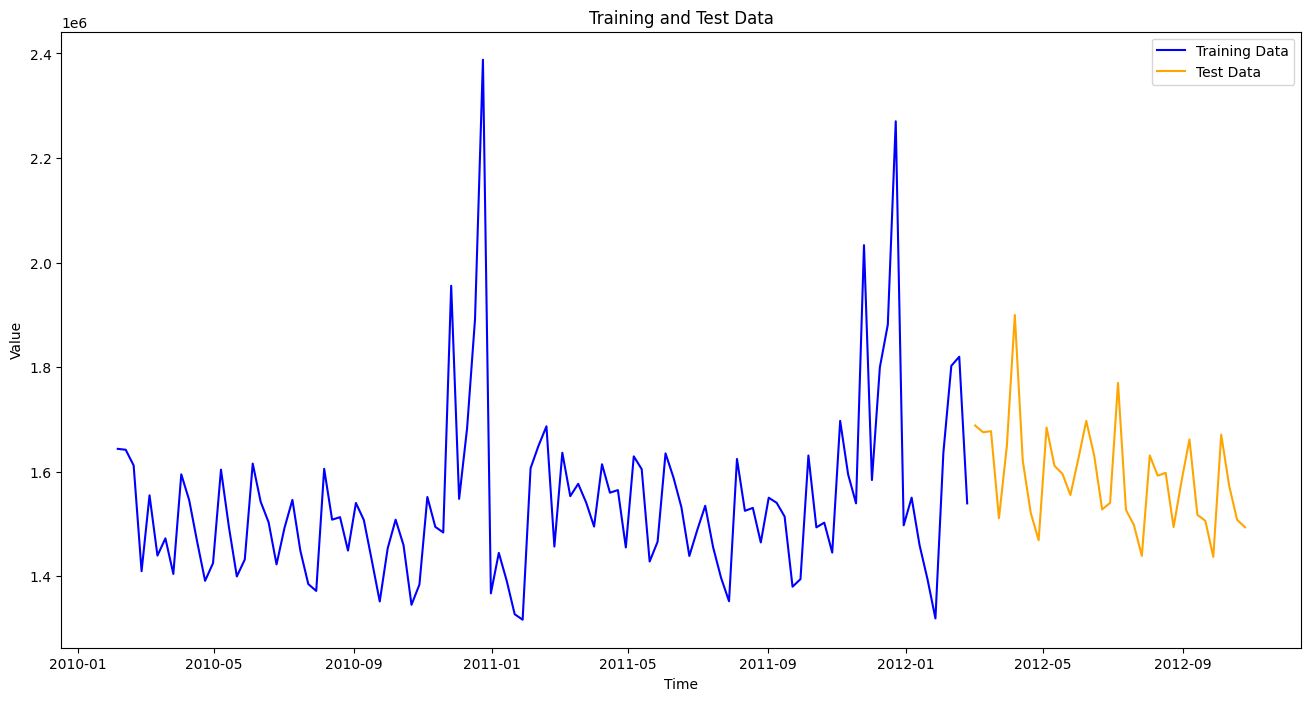

In [16]:
# Plotting train and test data
train_test_plot(train, test)

#### 6. AutoARIMA

We will be exploring two approaches to predict sales using <code>AutoARIMA</code>:
- ARIMA
- SARIMA


Evaluate each model's performance and provide comment on the model's performance .

In [17]:
# Create helper function to help make predictions and plot the results 
# function captures the same steps as previous lesson with just the addition of `X_test` to use for SARIMAX model next

def plot_forecast(y_train, y_test, arima_model, X_test=None):
    # Generate len(y_test) number of predictions
    y_pred = arima_model.predict(n_periods = len(y_test), X=X_test) # we want as many future data point predictions as there are in y_test

    # Plot data.
    plt.figure(figsize=(30,15))

    # Plot training data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_train, color='blue', label='y_train')

    # Plot testing data. don't need to explicitly pass x-axis for chart, taken as the date index by matplotlib
    plt.plot(y_test, color='orange', label='y_test', alpha = 0.7)

    # Plot predicted test values. as shared previously, there are no index in y_pred 
    # so, we need to explicitly pass the `x-axis` (dates) to compare for same timeframe as y_test and access y_pred vs actual y_test
    # we can use y_test.index to get the index of y_test as confirmed earlier in y_test.head()
    plt.plot(y_pred, color='green', label='y_pred', alpha = 0.9, ls = '--')
    
    # Find the MAPE (mean abs percentage error) of the predictions
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html
    mape = mean_absolute_percentage_error(y_test, y_pred) # like all sklearn metrics we've used, pass y_actual, y_pred

    plt.title(label = f'Sales Predictions\n MAPE: {mape:.2f}', fontsize=16) #\n is just for new line to print MAPE 1 line after header 'Sales Predictions', while .2f rounds MAPE to 2 decimals
    plt.legend(fontsize = 20, loc = 'upper left'); # for legend to be displayed in our plot

##### ARIMA

In [18]:
# Fit an ARIMA model
arima_model = pm.AutoARIMA(start_p=0, max_p=10, 
                           d=None,    # find optimum value of d automatically
                           start_q=0, max_q=10,
                           # start_P=0, max_P=10,
                           # D=None,
                           # start_Q=0, max_Q=10,
                           # m=12, # For monthly data since the pattern repeats every 12 months
                           # seasonal=True,
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

arima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2910.184, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2901.456, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2903.682, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3387.710, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2903.170, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2903.351, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2905.185, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.256 seconds


AutoARIMA(max_p=10, max_q=10, n_fits=50, random_state=20, start_p=0, start_q=0,
          trace=True)

In [19]:
# Summary results
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1447.728
Date:                Thu, 17 Aug 2023   AIC                           2901.456
Time:                        00:48:53   BIC                           2909.502
Sample:                    02-05-2010   HQIC                          2904.719
                         - 02-24-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.067e+06   9.76e+04     10.924      0.000    8.75e+05    1.26e+06
ar.L1          0.3092      0.056      5.548      0.000       0.200       0.418
sigma2      2.589e+10      0.571   4.54e+10      0.000    2.59e+10    2.59e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               195.46
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               4.46   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.72e+26. Standard errors may be unstable.
"""

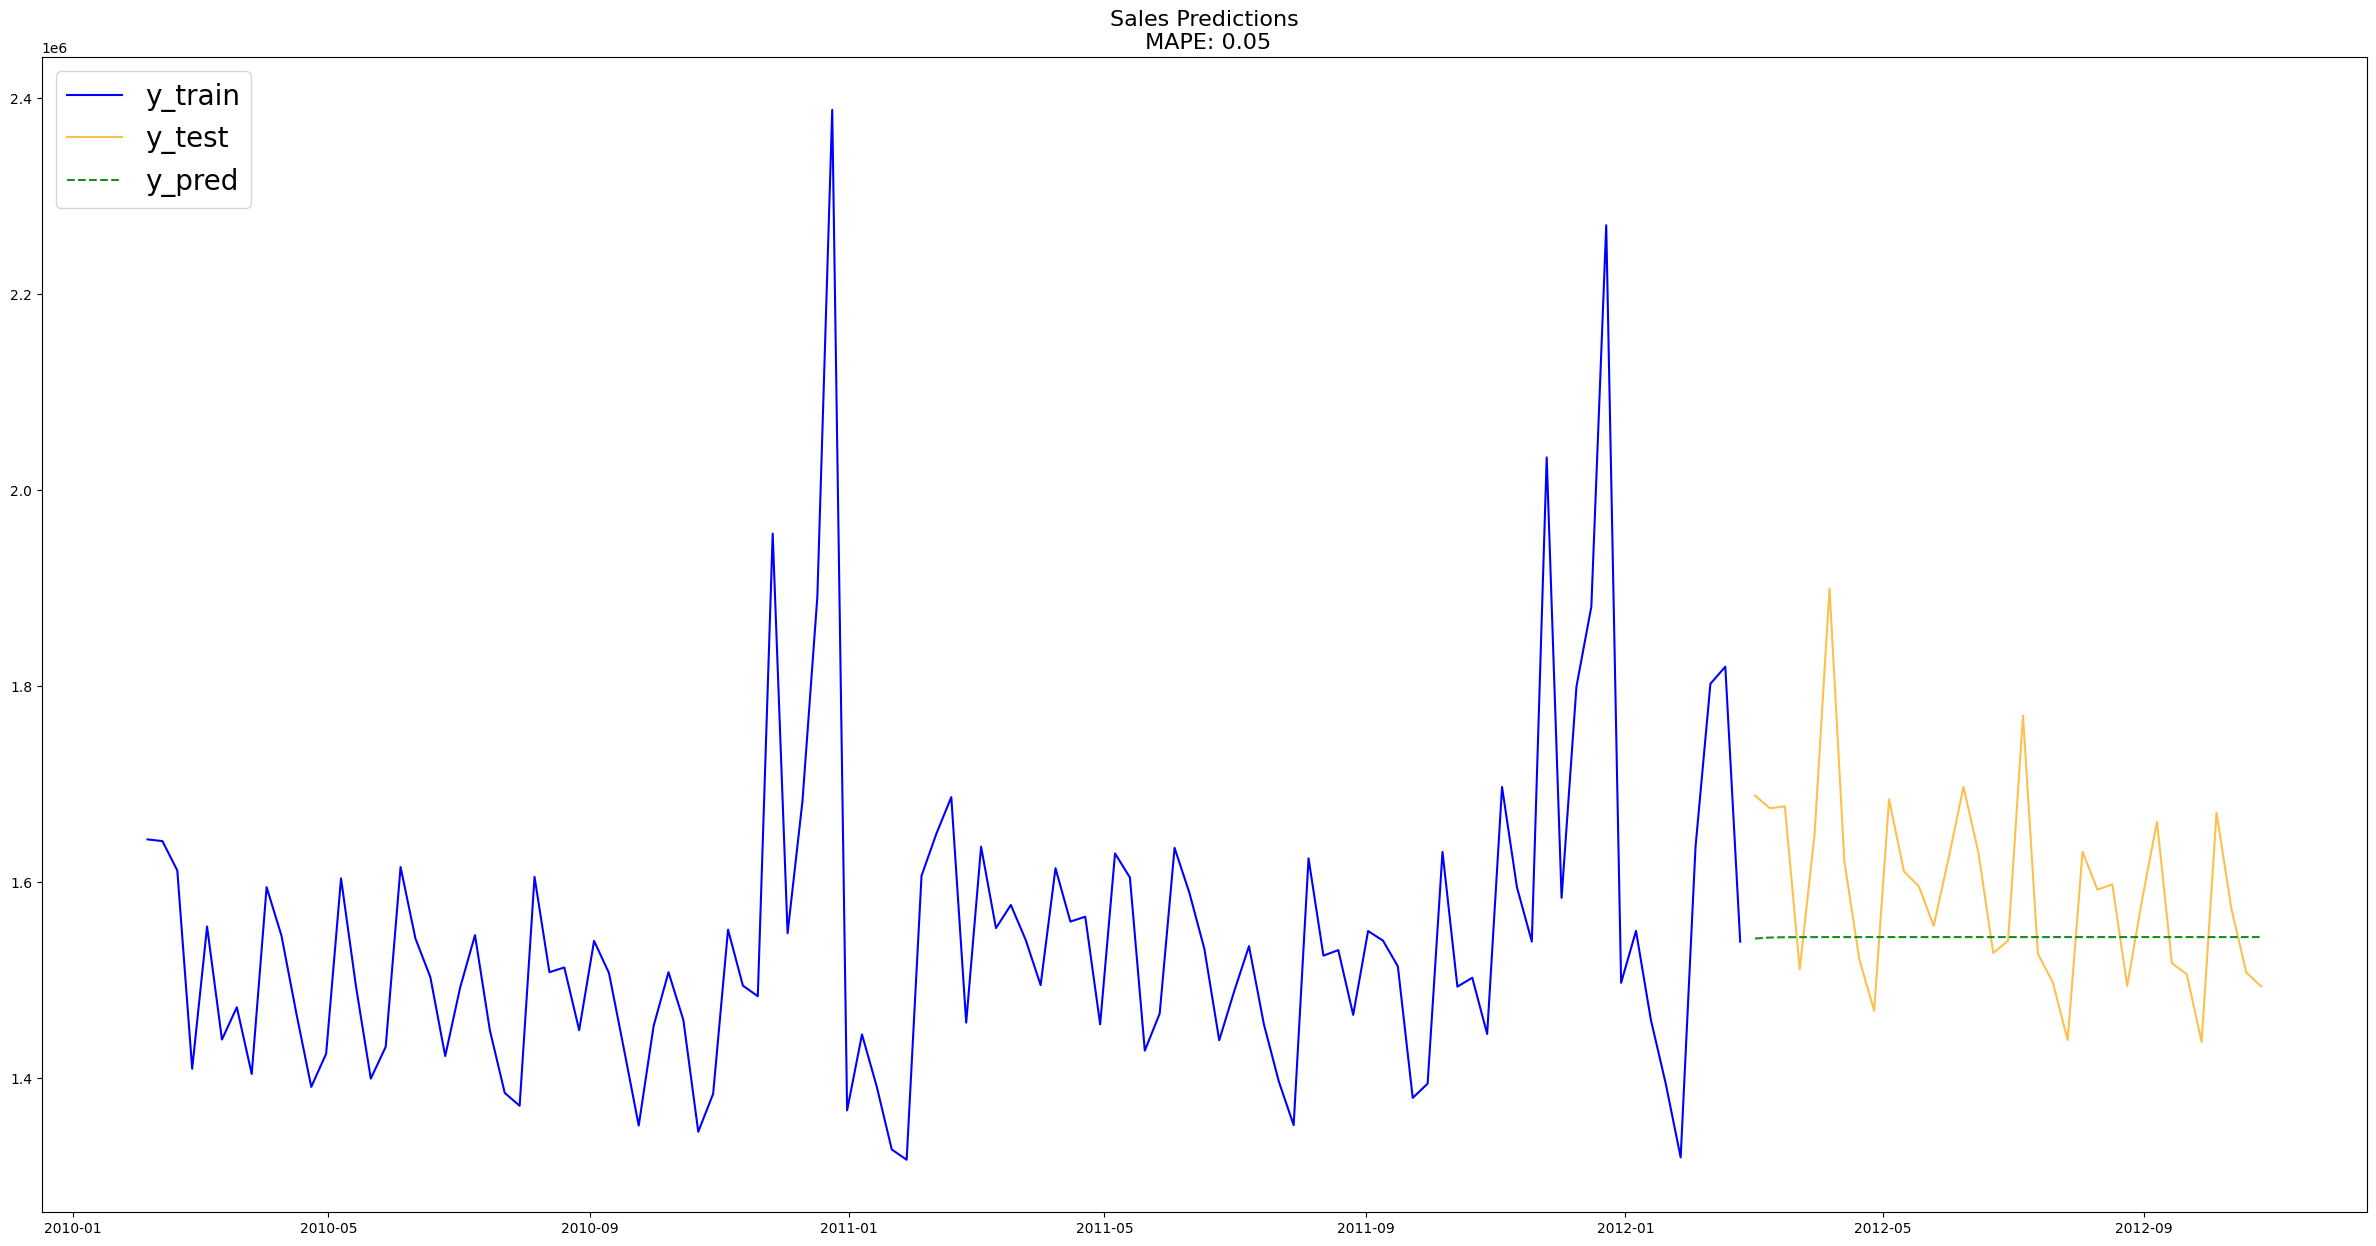

In [20]:
# Plotting ARIMA(1,0,0) 
plot_forecast(train, test, arima_model)

#### Note

ARIMA is just predicting the mean... I attach these 2 links for my reference. If I include seasonality, perhaps things will improve!

https://stats.stackexchange.com/questions/286900/arima-forecast-straight-line

https://stats.stackexchange.com/questions/124955/is-it-unusual-for-the-mean-to-outperform-arima/125016#125016

##### SARIMA

[BONUS] Investigating if there is seasonality in the data

Some ways we can explore if there is seasonality:
1. ACF plots
    - You will observe a periodic correlation pattern
1. [Seasonal decompose plots](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7)

Earlier from the ACF plot, there was no periodic corrrelation pattern observed.
Now, try running the following code cells and interprete if there is seasonality oberved.

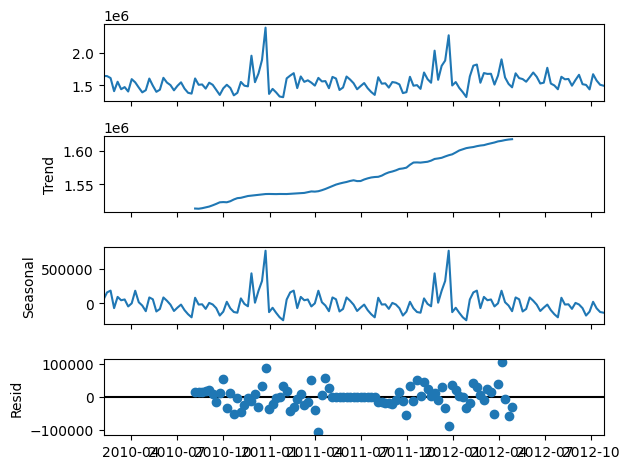

In [21]:
# Plotting seasonal decompose plots
decompose_result_add = seasonal_decompose(Weekly_Sales, model="additive")
decompose_result_add.plot();

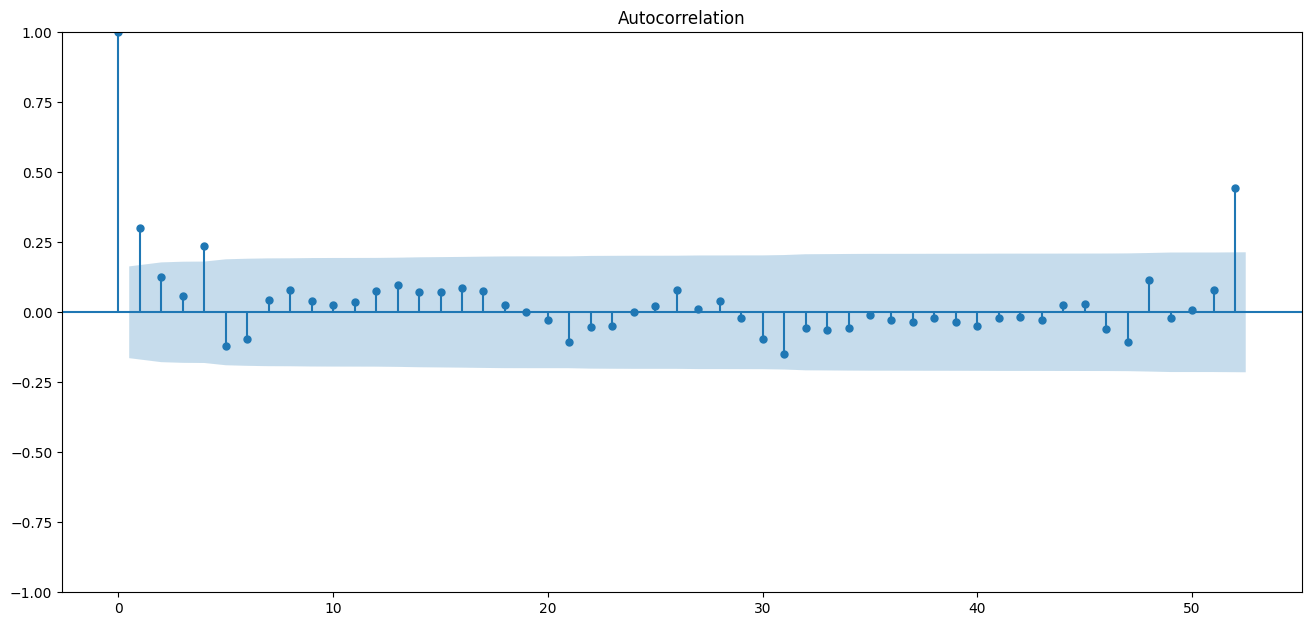

In [22]:
# This is the same 52 week Autocorrelation plot from above
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(Weekly_Sales.Weekly_Sales, lags=52, ax=ax1)

**Is there seasonality?**


**Answer**:

Yes there appears to be seasonality every 52 weeks.

**Plotting SARIMA**<br>

Assume there is seasonal pattern every 4 weeks, fit a SARIMA model and interpret the model's performance.

In [23]:
# Fit Auto SARIMA with seasonality of 4 weeks
sarima_model = pm.AutoARIMA(
                           # same parameters as Auto ARIMA
                           start_p=0, max_p=10, # we specify the start and end for our grid search
                           d=None,    # let Auto ARIMA automatically find optimum value of d automatically
                           start_q=0, max_q=10, # we specify the start and end for our grid search
                           
                           # uncomment these hyperparameter declarations to train SARIMA model this time
                           start_P=0, max_P=10, # tune `P` SARIMA hyperparameter between 0 to 10 same as `p`
                           D=None,    # let Auto ARIMA automatically find optimum value of D automatically
                           start_Q=0, max_Q=10, # tune `Q` SARIMA hyperparameter between 0 to 10 same as `q`
                           m=4, # this is the `S`! Since the peak occurs every 3 months!
                           seasonal=True, # HAS to be set to True to use `m`. goes in conjunction with `m`
                           
                           # same parameters as Auto ARIMA
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

sarima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2910.184, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=2900.026, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=2899.190, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3387.710, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=2903.682, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=2901.115, Time=0.10 sec
 ARIMA(0,0,1)(0,0,2)[4] intercept   : AIC=2901.172, Time=0.09 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=2905.400, Time=0.13 sec
 ARIMA(0,0,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=2909.054, Time=0.04 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=2897.777, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=2903.351, Time=0.05 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=2899.777, Time=0.18 sec
 ARIMA(1,0,1)(0,0,2)[4] intercept   : AIC=2899.763, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : 

AutoARIMA(m=4, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=50,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

In [24]:
# Sarima model summary with seasonality of 4 weeks
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 4)   Log Likelihood               -1444.094
Date:                             Thu, 17 Aug 2023   AIC                           2896.189
Time:                                     00:48:59   BIC                           2906.917
Sample:                                 02-05-2010   HQIC                          2900.539
                                      - 02-24-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.067e+06   1.09e+05      9.784      0.000    8.53e+05    1.28e+06
ar.L1          0.3117      0.063      4.987      0.000       0.189       0.434
ma.S.L4        0.2731      0.059      4.650      0.000       0.158       0.388
sigma2      2.589e+10      0.249   1.04e+11      0.000    2.59e+10    2.59e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                77.56
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               5.02   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+27. Standard errors may be unstable.
"""

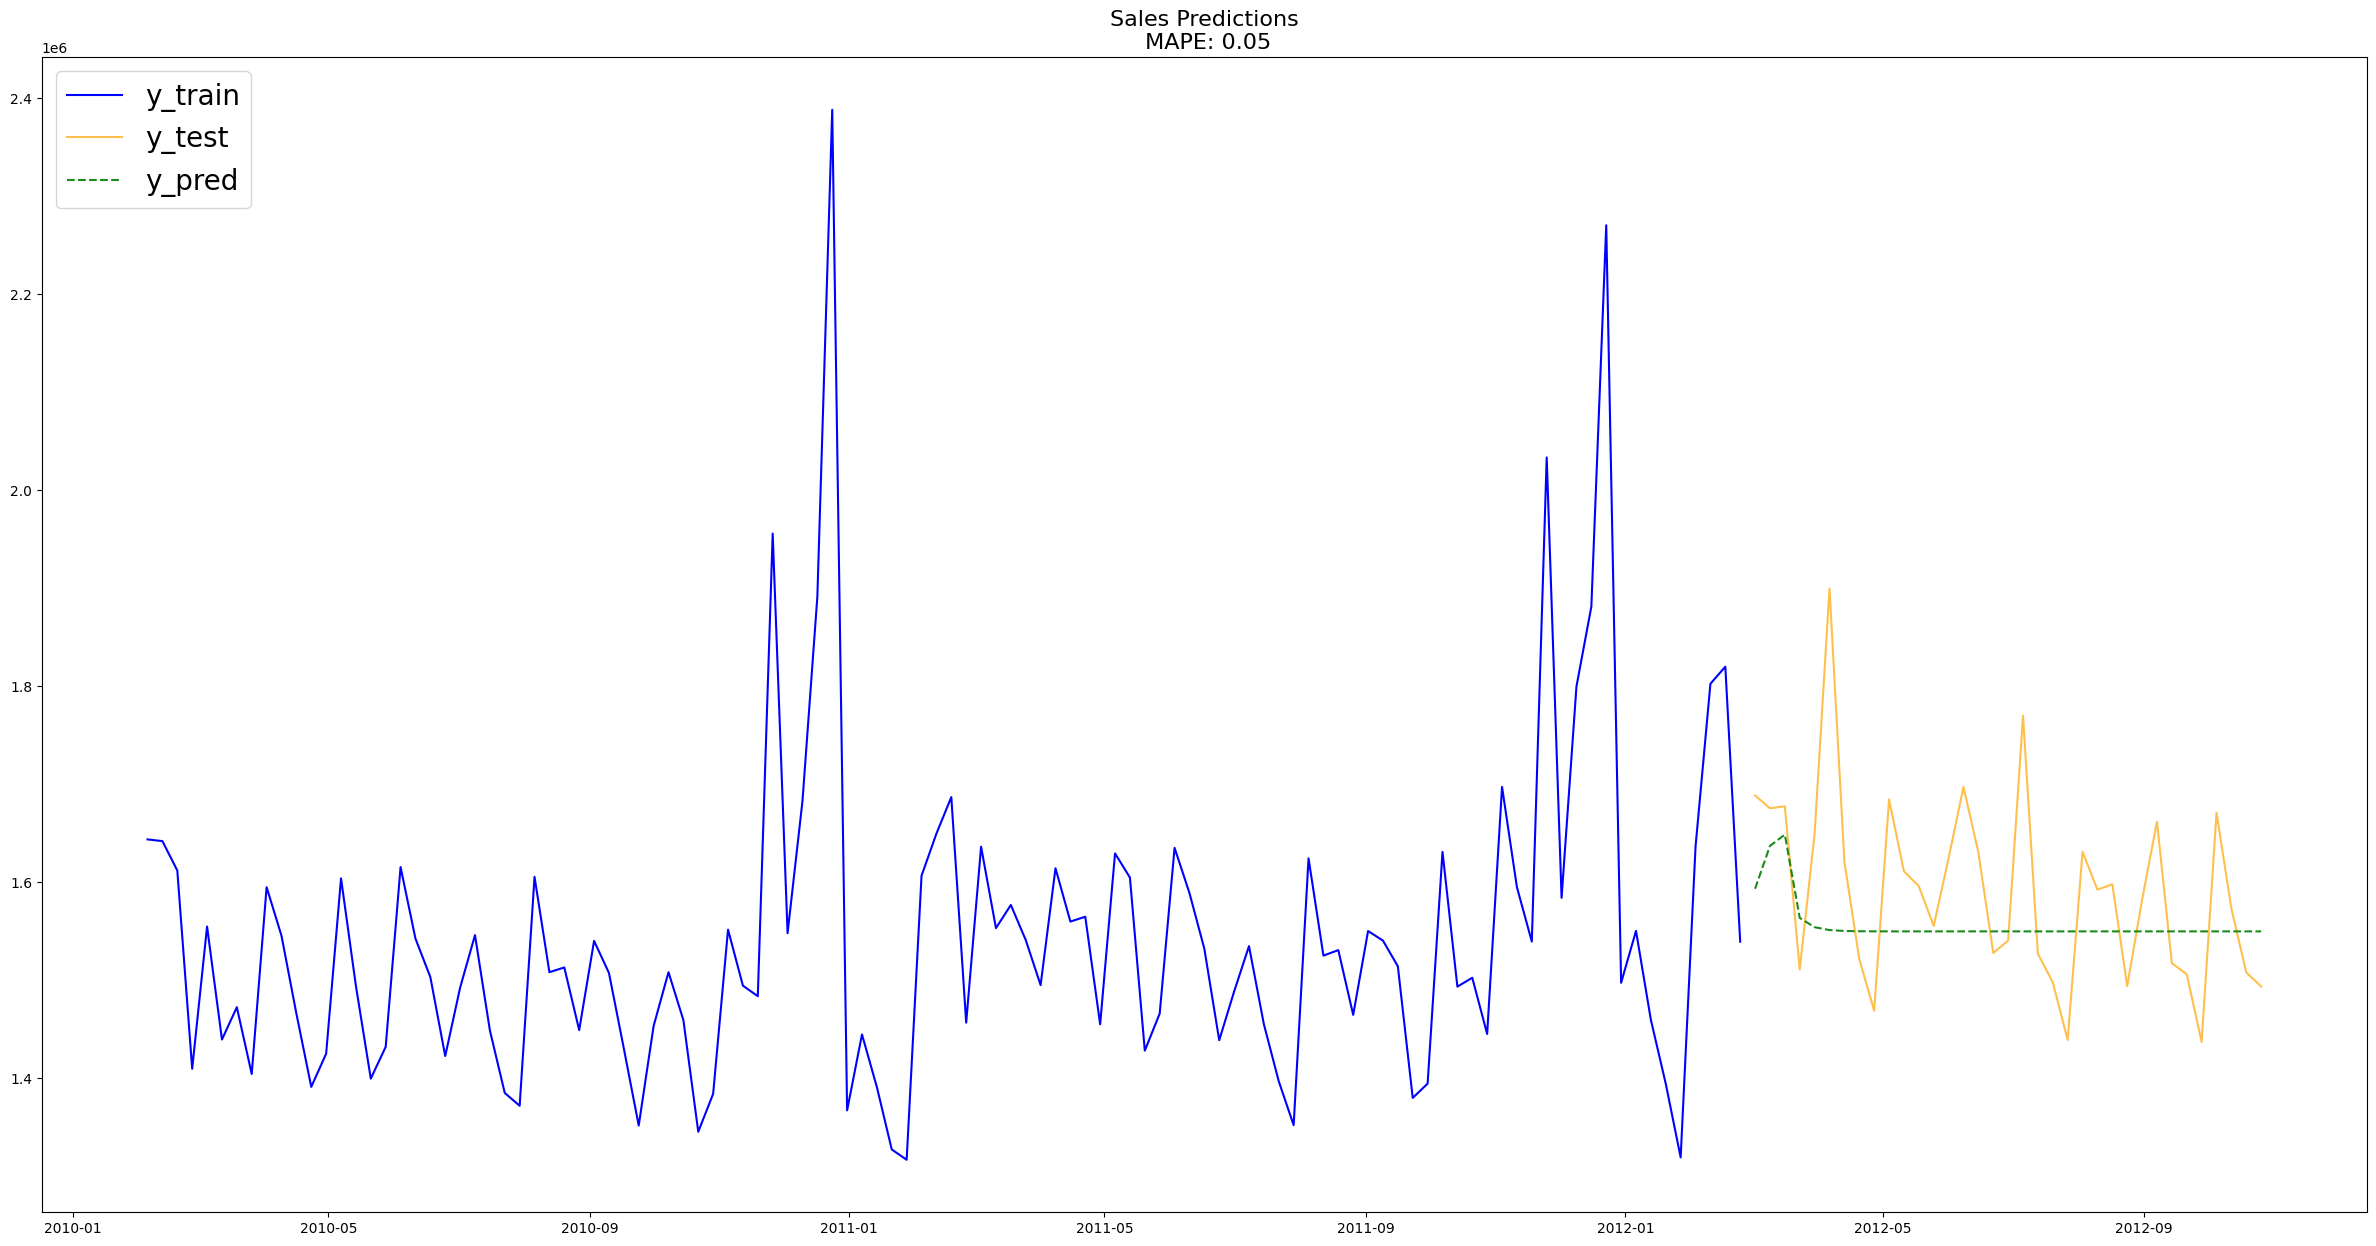

In [25]:
# Plotting SARIMA(1, 0, 0)(0, 0, [1], 4) with an assumed seasonality of 4
plot_forecast(train, test, sarima_model)

In [26]:
# Fit Auto SARIMA with seasonality of 52 weeks
sarima_model = pm.AutoARIMA(
                           # same parameters as Auto ARIMA
                           start_p=0, max_p=10, # we specify the start and end for our grid search
                           d=None,    # let Auto ARIMA automatically find optimum value of d automatically
                           start_q=0, max_q=10, # we specify the start and end for our grid search
                           
                           # uncomment these hyperparameter declarations to train SARIMA model this time
                           start_P=0, max_P=10, # tune `P` SARIMA hyperparameter between 0 to 10 same as `p`
                           D=None,    # let Auto ARIMA automatically find optimum value of D automatically
                           start_Q=0, max_Q=10, # tune `Q` SARIMA hyperparameter between 0 to 10 same as `q`
                           m=52, # this is the `S`! Since the peak occurs every 3 months!
                           seasonal=True, # HAS to be set to True to use `m`. goes in conjunction with `m`
                       
                           # same parameters as Auto ARIMA
                           trace=True, # Print values for each fit in the grid search
                           random_state=20,
                           n_fits=50
                          )

sarima_model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2910.184, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2886.860, Time=0.92 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2880.671, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3387.710, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=2903.682, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=2882.561, Time=0.66 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=2878.097, Time=4.76 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=2880.065, Time=6.00 sec
 ARIMA(0,0,1)(0,0,3)[52] intercept   : AIC=2878.863, Time=7.86 sec
 ARIMA(0,0,1)(1,0,3)[52] intercept   : AIC=2880.846, Time=11.68 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=2881.582, Time=4.13 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=2875.176, Time=8.81 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=2878.190, Time=0.63 sec
 ARIMA(1,0,1)(1,0,2)[52] intercept   : AIC=2876.716, Time=50.22 sec
 ARIMA(1,0,1)(0,0

AutoARIMA(m=52, max_P=10, max_Q=10, max_p=10, max_q=10, n_fits=50,
          random_state=20, start_P=0, start_Q=0, start_p=0, start_q=0,
          trace=True)

In [27]:
# Sarima model summary with seasonality of 52 weeks
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  108
Model:             SARIMAX(1, 0, 0)x(0, 0, [1, 2], 52)   Log Likelihood               -1431.209
Date:                                 Thu, 17 Aug 2023   AIC                           2872.418
Time:                                         00:54:24   BIC                           2885.829
Sample:                                     02-05-2010   HQIC                          2877.856
                                          - 02-24-2012                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.067e+06   1.76e+05      6.069      0.000    7.22e+05    1.41e+06
ar.L1          0.3092      0.097      3.201      0.001       0.120       0.499
ma.S.L52       0.5886      1.680      0.350      0.726      -2.705       3.882
ma.S.L104      0.2734      3.639      0.075      0.940      -6.860       7.406
sigma2      2.589e+10      0.144    1.8e+11      0.000    2.59e+10    2.59e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               301.14
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             1.59
Prob(H) (two-sided):                  0.13   Kurtosis:                        10.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.06e+27. Standard errors may be unstable.
"""

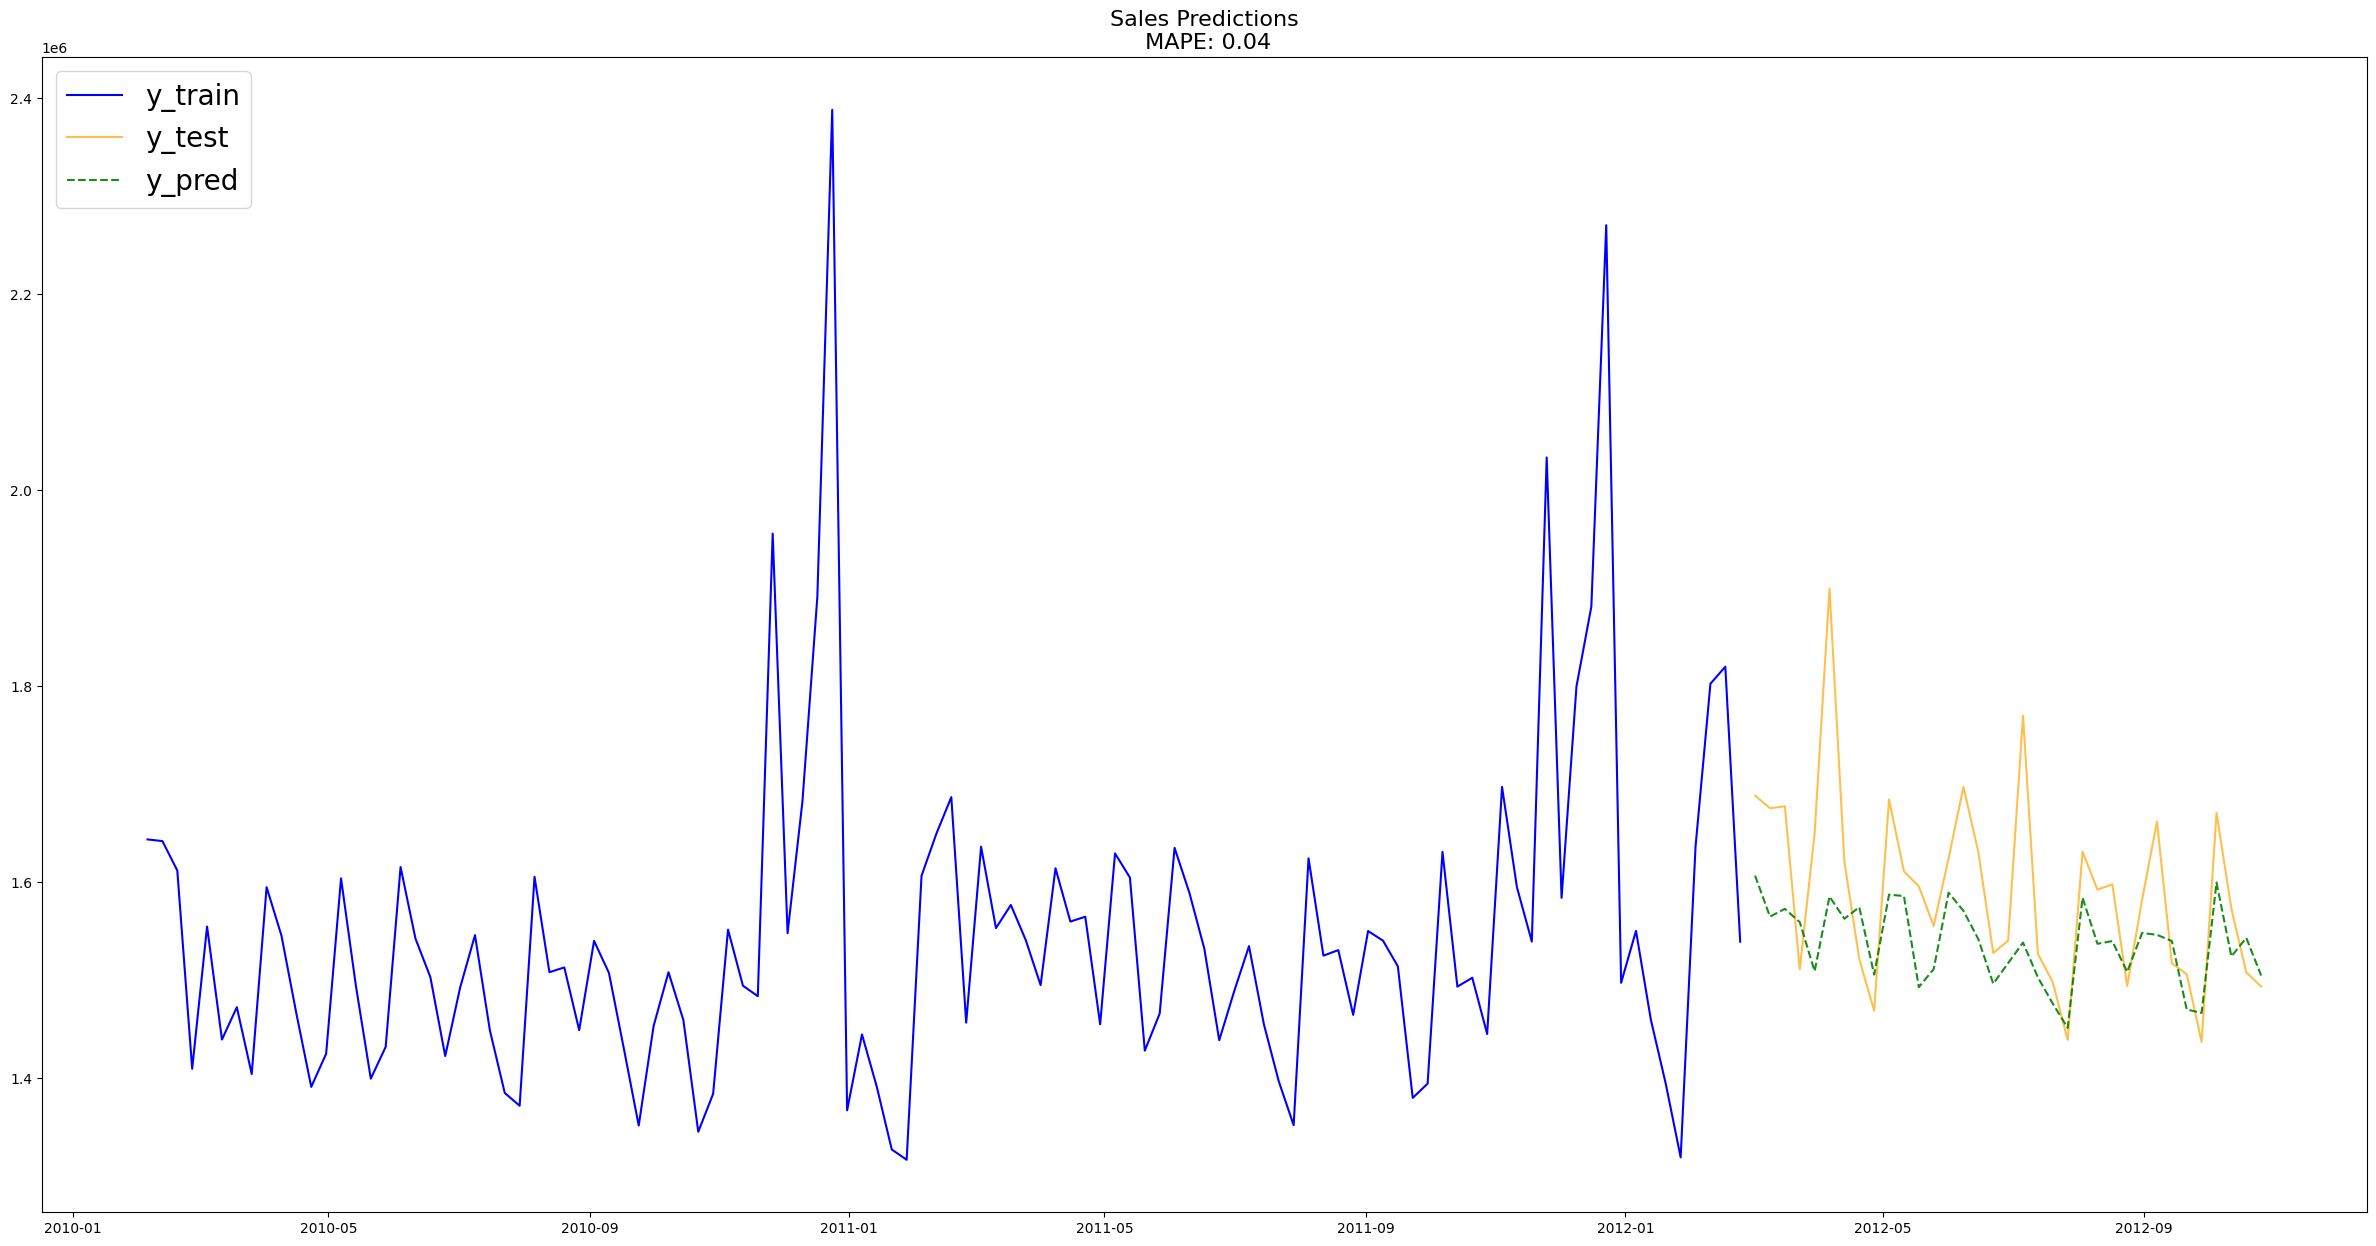

In [28]:
# Plotting SARIMA(1, 0, 0)(0, 0, [2], 52) with an assumed seasonality of 52
plot_forecast(train, test, sarima_model)

## How might you improve the model performance?

**Answer:**

After fitting a SARIMA model with a seasonality of 52 periods (for 52 weeks) we can see that the predictions start to mimic the test set. We should probably account for exogenous variables using a SARIMAX model.

## (BONUS)

#### 1. Autoregressive Model
We will start by building a simple autoregressive model first: the `AR(1)` model.<br>
In each section, we will add additional ARIMA parameters in an effort to improve our modeling. <br>
Note that sometimes the model you attempt is not effective or the best. <br>

- Note that this is the same thing as an `ARIMA(1,0,0)` model.
- Pass in the Weekly Sales as an `ndarray`, not a `Series`.
- Pass in the training index using the ARIMA `dates` parameter.

**1a. Instantiate and fit an `AR(1)` model.**

In [29]:
# Split training data into train values and dates.
train_values = train['Weekly_Sales'].values
train_dates = train.index

# Split test data into values and dates.
test_values = test['Weekly_Sales'].values
test_dates = test.index

# Create start and end dates for predictions
start = test_dates[0]  # Start date is the first date in the test set
end = test_dates[-1]    # End date is the last date in the test set

# Generate a list of dates for the prediction period
date_list = pd.date_range(start, periods=35, freq='W')


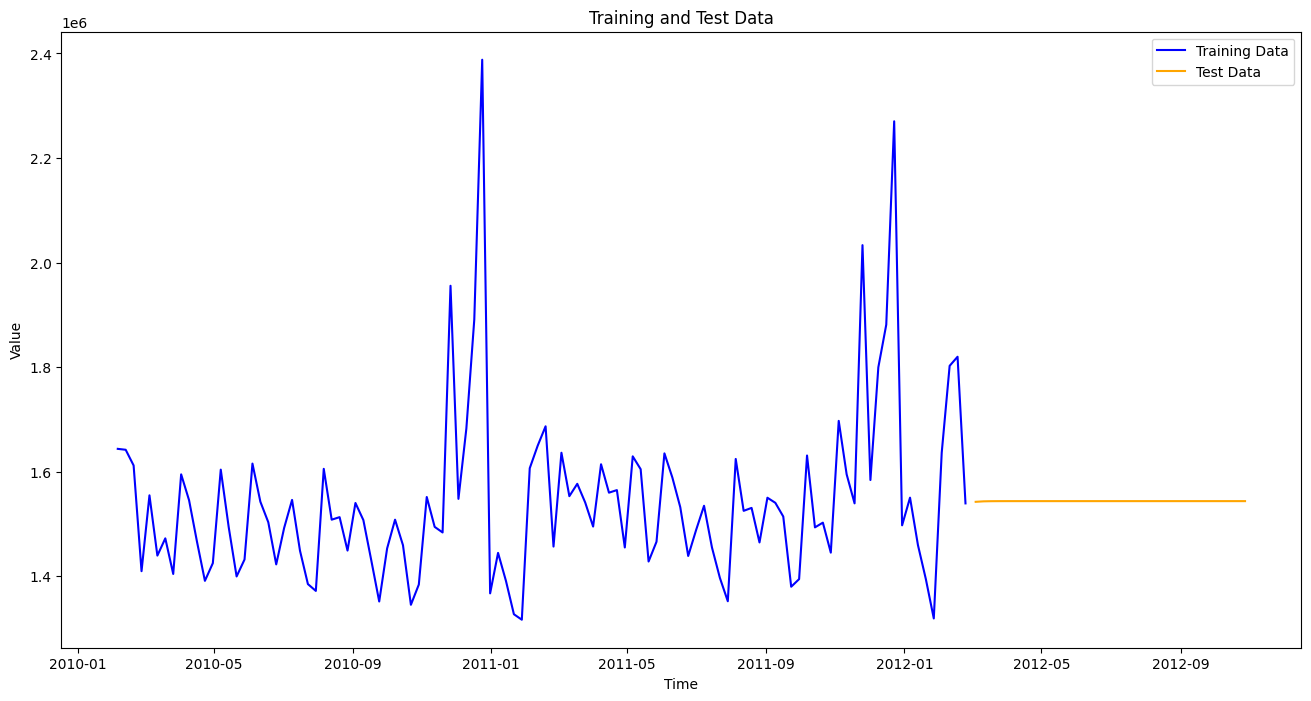

In [30]:
# Fit an AR(1) model.
AR1 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (1,0,0)).fit()

# Generate predictions.
AR1_pred = AR1.predict(start = 108,
                       end = 142)

preds = pd.DataFrame(AR1_pred, index=date_list, columns = ['Weekly Sales'])

# Plot AR(1) model predictions
train_test_plot(train, preds)

**1b. Calculate the Mean Squared Error of the `AR(1)` on your training set and your test set.**


In [31]:
# Evaluate our model on the training and testing sets.
print(f'Training MSE: {mean_squared_error(train_values, AR1.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR1_pred)}')

Training MSE: 25739768000.964268
Testing MSE: 11496534849.290201


**1c. How effective do you think this `AR(1)` model is?**

In [32]:
# Look at min and max sales, as well as how our RMSE compares to them.
print(f'Minimum Sales: {round(Weekly_Sales["Weekly_Sales"].min(),2)}')
print(f'Maximum Sales: {round(Weekly_Sales["Weekly_Sales"].max(),2)}')

# Calculate the RMSE for the training and test data
train_RMSE = mean_squared_error(train_values, AR1.predict()) ** 0.5
test_RMSE = mean_squared_error(test_values, AR1_pred) ** 0.5

# Compare the minimum and maximum sales values to the respective RMSE values
print(f'Minimum values in series relative to Train RMSE: {round(Weekly_Sales["Weekly_Sales"].min() / train_RMSE, 2)}.')
print(f'Maximum values in series relative to Test RMSE: {round(Weekly_Sales["Weekly_Sales"].max() / test_RMSE, 2)}.')

Minimum Sales: 1316899.31
Maximum Sales: 2387950.2
Minimum values in series relative to Train RMSE: 8.21.
Maximum values in series relative to Test RMSE: 22.27.


Answer: Looking at the ratio of the minimum and maximum values to the root mean squared error in the series, it does not seem terrible. However (as we'll see shortly), when you look at the residuals based on the graph, it is clear that the residuals are not of the same magnitude throughout the date range of interest.

#### 2. Residual Plot  
Mean squared error is a good way to evaluate our model's performance. However, this doesn't tell the whole story. Is our model off by a lot in one specific window of time? Is our model only slightly off, but over all time? It might be helpful to plot residuals to see when our model is off most.

**2a. Calculate and and plot the residuals of your `AR(1)` model.**<br> (*Remember that a residual is just the actual value minus the predicted value.*)

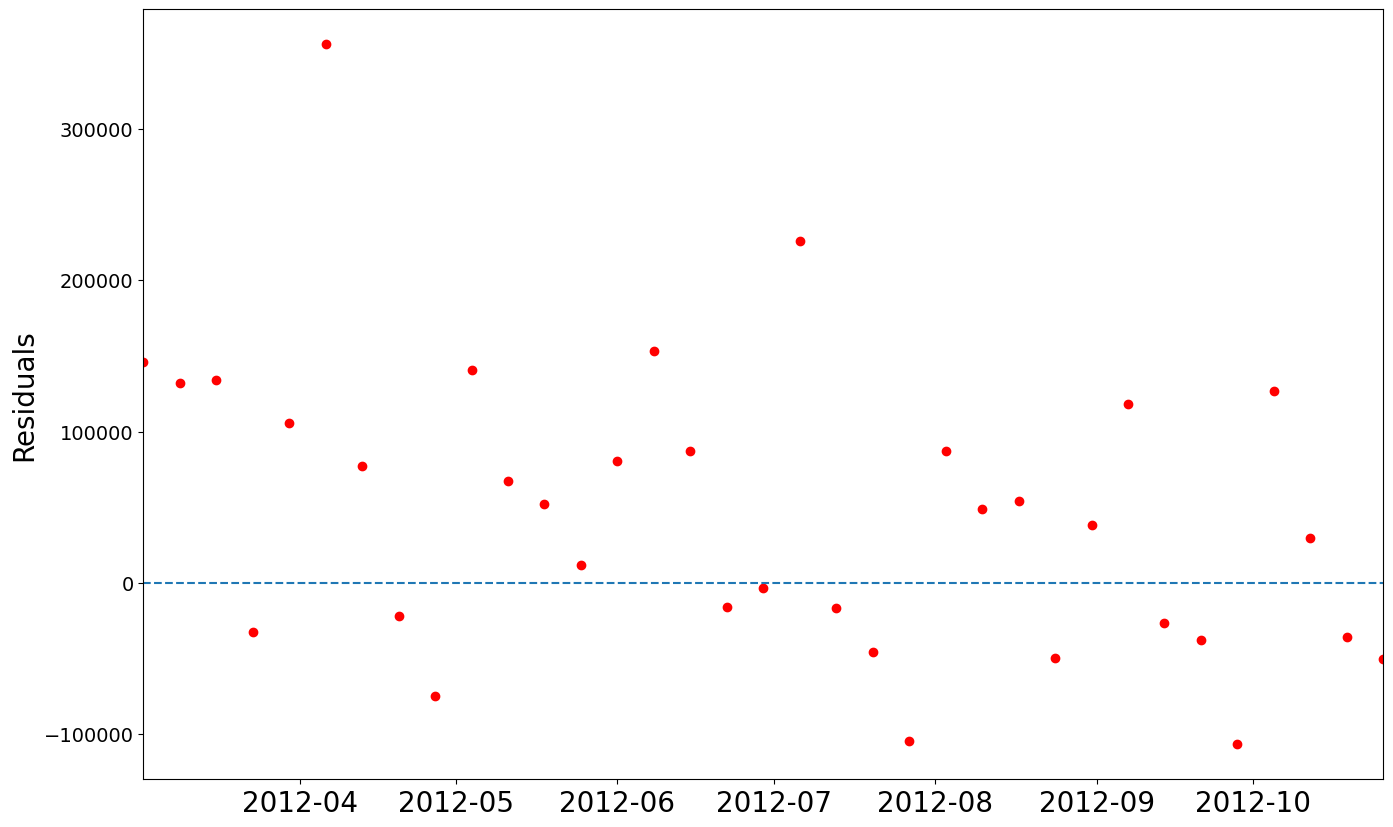

In [33]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

From this plot we can see that there are clearly errors in our predictions. 

**2b. What do the residual plots reveal about our model?**

Answer:

There are some weeks where the prediction is off more than others. This could be specific to those weeks, or it could be a limit of the model. It looks like early time periods are predicting too low values (residuals are large) and later time periods are predicting closer to accurate values (residuals centered around 0).

#### 3. AR vs. ARMA Models 


**3a. Let's fit an `AR(2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.**

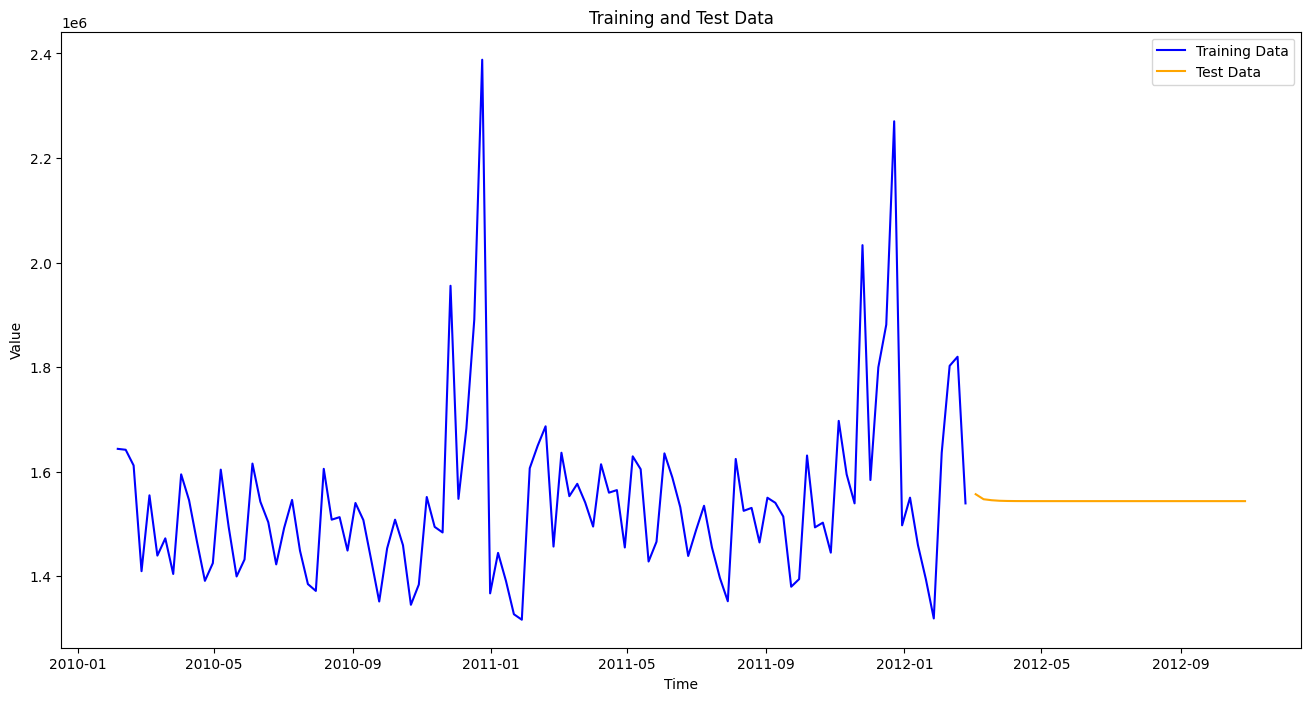

In [34]:
# Fit an AR(2) model.
AR2 = ARIMA(endog = train_values,
            dates = train_dates,
            order = (2,0,0)).fit()

# Generate predictions.
AR2_pred = AR2.predict(start = 108,
                       end = 142)

preds = pd.DataFrame(AR2_pred, index=date_list, columns = ['Weekly Sales'])

# Plot AR(2) model predictions
train_test_plot(train, preds)

In [35]:
# Evaluate our model on the training and testing sets.
print(f'Training MSE: {mean_squared_error(train_values, AR2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_pred)}')

Training MSE: 25669030880.49079
Testing MSE: 11333914061.724726


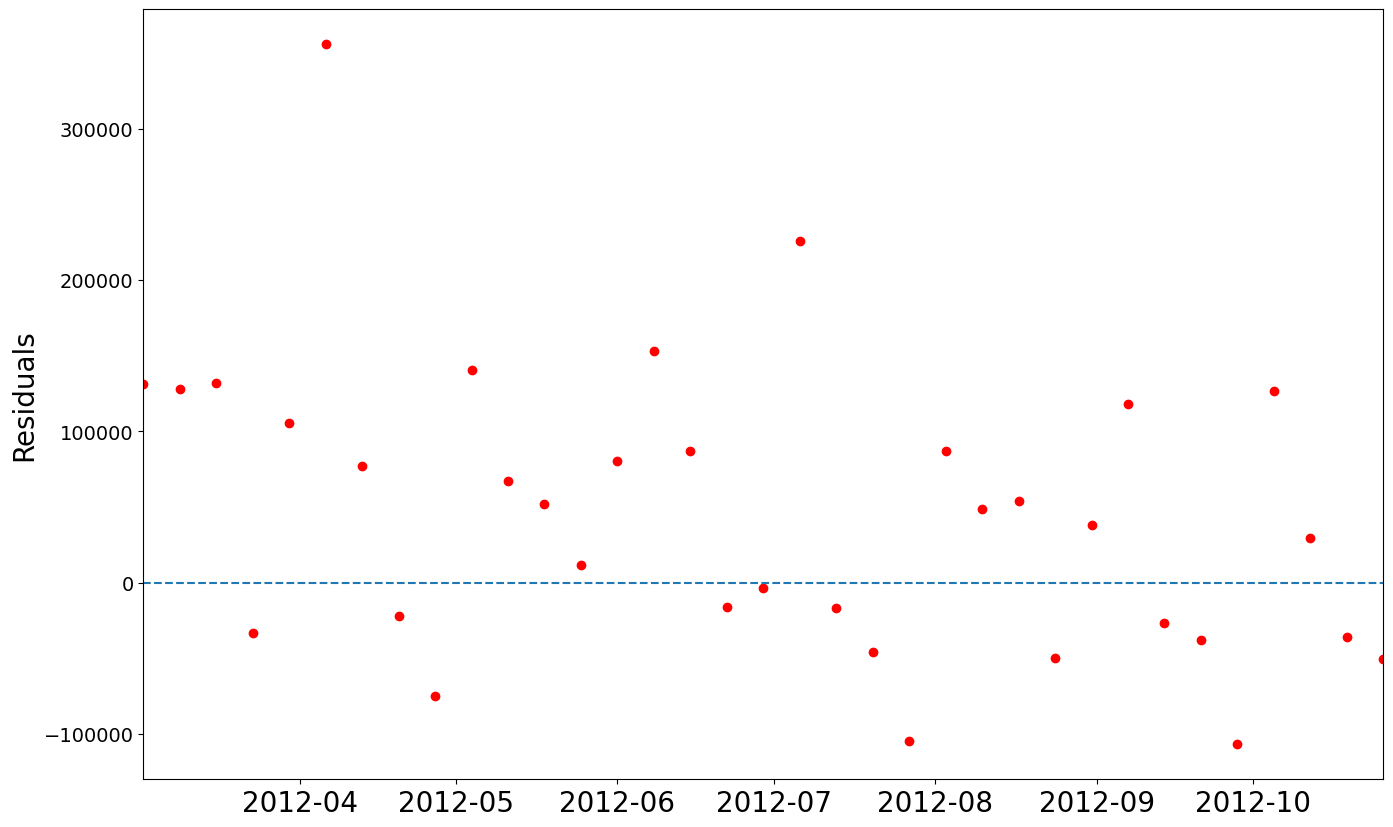

In [36]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**3b. How did your results change?**

Train and test MSE improved by a little bit.

**3c. Fit an `ARMA(2,2)` model. Calculate the MSE on the training and testing sets, then plot the residuals.** (_Note that an `ARMA(2,2)` model is the same as an `ARIMA(2,0,2)` model._)

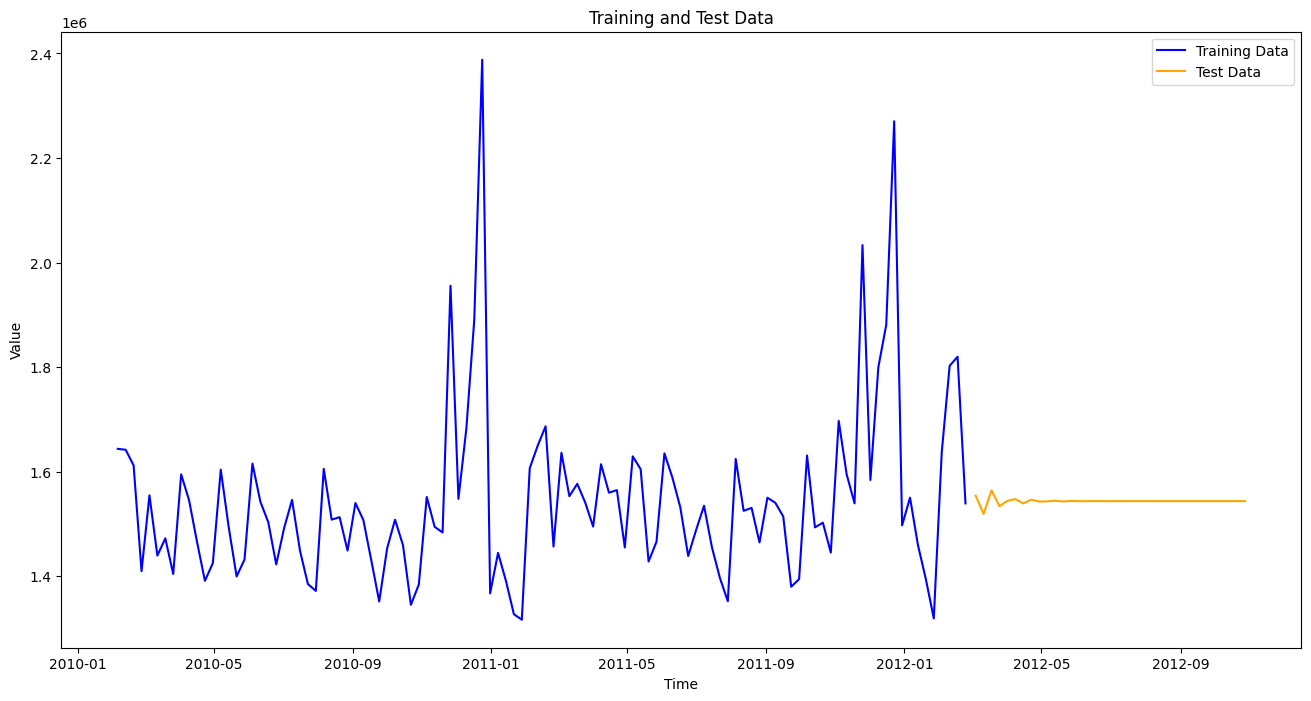

In [37]:
# Fit an AR(2,2) model.
AR2_2 = ARIMA(endog = train_values,
              dates = train_dates,
              order = (2,0,2)).fit()

# Generate predictions.
AR2_2_pred = AR2_2.predict(start = 108,
                           end = 142)

preds = pd.DataFrame(AR2_2_pred, index=date_list, columns = ['Weekly Sales'])

# Plot ARMA(2,2) model predictions
train_test_plot(train, preds)

In [38]:
# Evaluate our model on the training and testing sets
print(f'Training MSE: {mean_squared_error(train_values, AR2_2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, AR2_2_pred)}')

Training MSE: 21403410708.952328
Testing MSE: 11379292741.273352


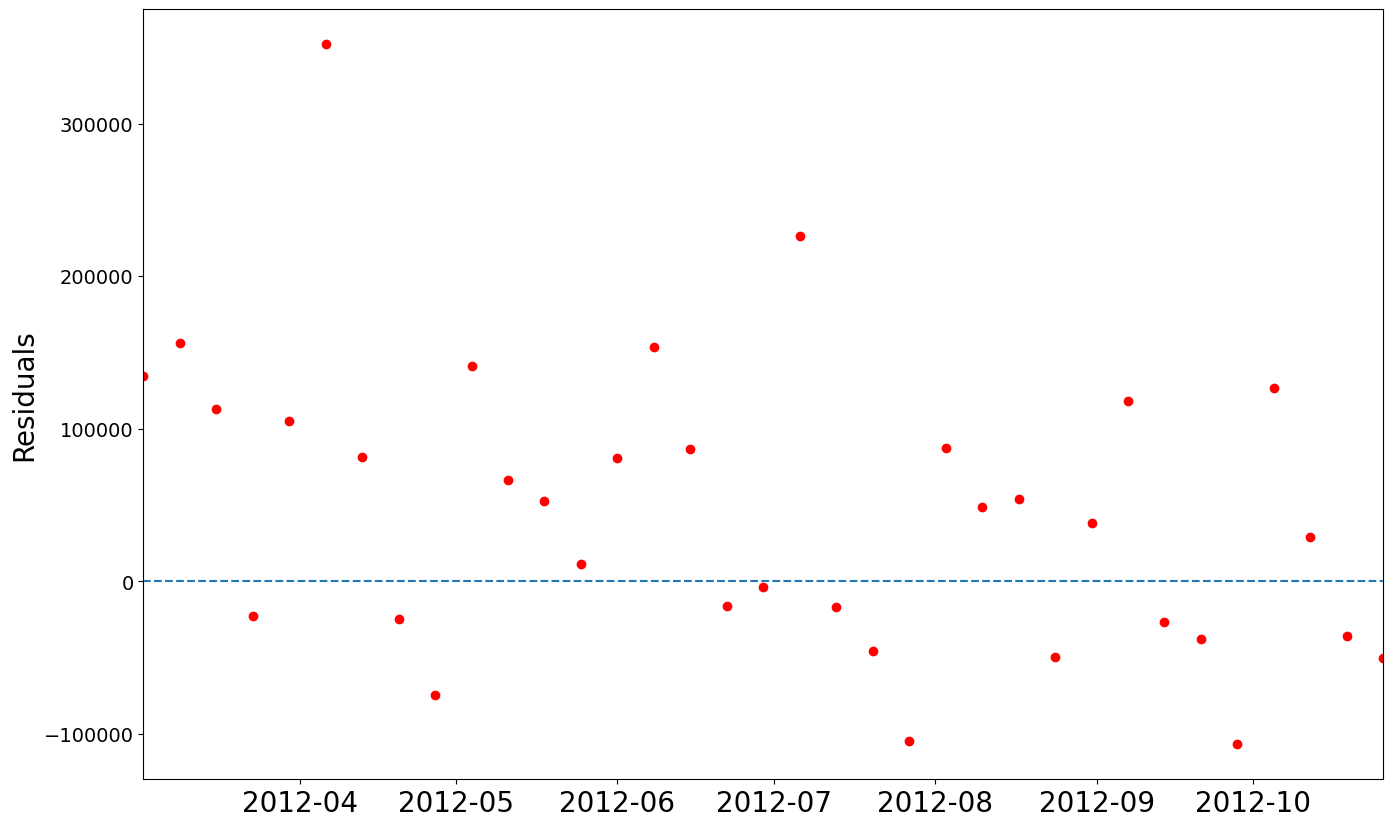

In [39]:
# Set figure size.
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**3d. How do the errors and residuals change from `AR(2)` to `ARMA(2,2)`?**



Only the train MSE got better. The test MSE remained about the same (actually got slightly worse).

#### 4. Stationary Data

Remember that one assumption to using the ARIMA model is that our data are **stationary**. This is a necessary assumption for our model, and it is important for us to check for it whenever we fit a time series model.

**4a. Use the Augmented Dickey-Fuller test to estimate whether or not your data are stationary.**

In [40]:
def my_dickey_fuller(data):
    """
    Perform Dickey-Fuller test on the given data.
    
    Parameters:
        data (Series or DataFrame): The data to be tested.
    """
    # Remove any missing values from the data, just in case
    data = data.dropna()
    
    # Print the header for the Dickey-Fuller test results
    print('\t\t\033[1mResults of Dickey-Fuller Test\033[0m\n\n')
    
    # Perform the Dickey-Fuller test on the data
    df_test = adfuller(data, maxlag=0, autolag=None)
    
    # Print the test statistic and other test results
    print(f'Test Statistic \t\t\t\t {round(df_test[0], 2)}')
    print(f'p-value \t\t\t\t {df_test[1]}')
    print(f'Lags Used \t\t\t\t {round(df_test[2], 2)}')
    print(f'Number of Observations \t\t\t {round(df_test[3], 2)}')
    
    # Print critical values for different confidence levels
    for key, value in df_test[4].items():
        print(f'Critical Value {key} \t\t\t {round(value, 2)}')


In [41]:
# Perform the Dickey-Fuller test on the 'Weekly_Sales' column to assess stationarity
my_dickey_fuller(Weekly_Sales['Weekly_Sales'])

		Results of Dickey-Fuller Test


Test Statistic 				 -8.67
p-value 				 4.5968274410764133e-14
Lags Used 				 0
Number of Observations 			 142
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58


**4b. Interpret the results of the Augmented Dickey-Fuller test.**

Because $p \approx 4.59\times 10^{-14} < 0.05 = \alpha$, we reject $H_0$ that our data are not stationary and accept $H_A$ that our data are stationary. This means we can fit an ARIMA model to this data without differencing.

#### 5. Differenced Data

**5a. Create new columns in your `Weekly_Sales` dataframe.**
- One column should be `Weekly_Sales` differenced by 1 time period.
- Another column should be `Weekly_Sales` differenced by 2 time periods.
- Another column should be `Weekly_Sales` differenced by 3 time periods.
- Another column should be `Weekly_Sales` differenced by 4 time periods.

In [42]:
# Calculate first-order differences and add them to the DataFrame
Weekly_Sales['diff_1'] = Weekly_Sales['Weekly_Sales'].diff()

# Calculate second-order differences and add them to the DataFrame
Weekly_Sales['diff_2'] = Weekly_Sales['Weekly_Sales'].diff(2)

# Calculate third-order differences and add them to the DataFrame
Weekly_Sales['diff_3'] = Weekly_Sales['Weekly_Sales'].diff(3)

# Calculate fourth-order differences and add them to the DataFrame
Weekly_Sales['diff_4'] = Weekly_Sales['Weekly_Sales'].diff(4)

# Display the updated DataFrame with the added difference columns
Weekly_Sales.head()

,Weekly_Sales,diff_1,diff_2,diff_3,diff_4
Date,,,,,
2010-02-05,1643690.900,NaN,NaN,NaN,NaN
2010-02-12,1641957.440,-1733.460,NaN,NaN,NaN
2010-02-19,1611968.170,-29989.270,-31722.730,NaN,NaN
2010-02-26,1409727.590,-202240.580,-232229.850,-233963.310,NaN
2010-03-05,1554806.680,145079.090,-57161.490,-87150.760,-88884.220


**5b. Conduct and interpret the Augmented Dickey-Fuller test on each differenced column to test for stationarity.**

In [43]:
# Loop through different levels of differencing (1 to 4)
for diff in range(1, 5):
    # Print the header for the current level of differencing
    print(f'Data Differenced by d = {diff}')
    print('')
    
    # Perform the Dickey-Fuller test on the differenced data
    my_dickey_fuller(Weekly_Sales[f'diff_{diff}'])
    print('')


Data Differenced by d = 1

		Results of Dickey-Fuller Test


Test Statistic 				 -17.5
p-value 				 4.3860500615947114e-30
Lags Used 				 0
Number of Observations 			 141
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 2

		Results of Dickey-Fuller Test


Test Statistic 				 -10.21
p-value 				 5.551624171726905e-18
Lags Used 				 0
Number of Observations 			 140
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 3

		Results of Dickey-Fuller Test


Test Statistic 				 -10.31
p-value 				 3.216664733095444e-18
Lags Used 				 0
Number of Observations 			 139
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Critical Value 10% 			 -2.58

Data Differenced by d = 4

		Results of Dickey-Fuller Test


Test Statistic 				 -7.3
p-value 				 1.383854592508419e-10
Lags Used 				 0
Number of Observations 			 138
Critical Value 1% 			 -3.48
Critical Value 5% 			 -2.88
Crit

**5c. For which (if any) of the columns does it seem meaningful to have differenced the data?**

The data appear to be stationary in all cases. Since the smallest differencing needed is $d = 0$, I recommend not differencing.

**5d. Based on these tests and the ACF/PACF plots above, do you think that using an Integrated AutoRegressive Moving Average (ARIMA) model makes sense? Why or why not?**

Given that the data is stationary, it does not seem necessary to use an ARIMA model, since the 'd' for the integrated part would just be 0.

#### 6.  ARIMA MODEL

Based on your interpretation of the results from your tests for stationarity, and information gleaned from your ACF and PACF plots, choose a value of `d` to use in the `ARIMA(2,d,2)`.

**6a. Fit an `ARIMA(2,d,2)` model for the value of `d` you have chosen. Evaluate your model on the training and testing sets and generate a residual plot.**

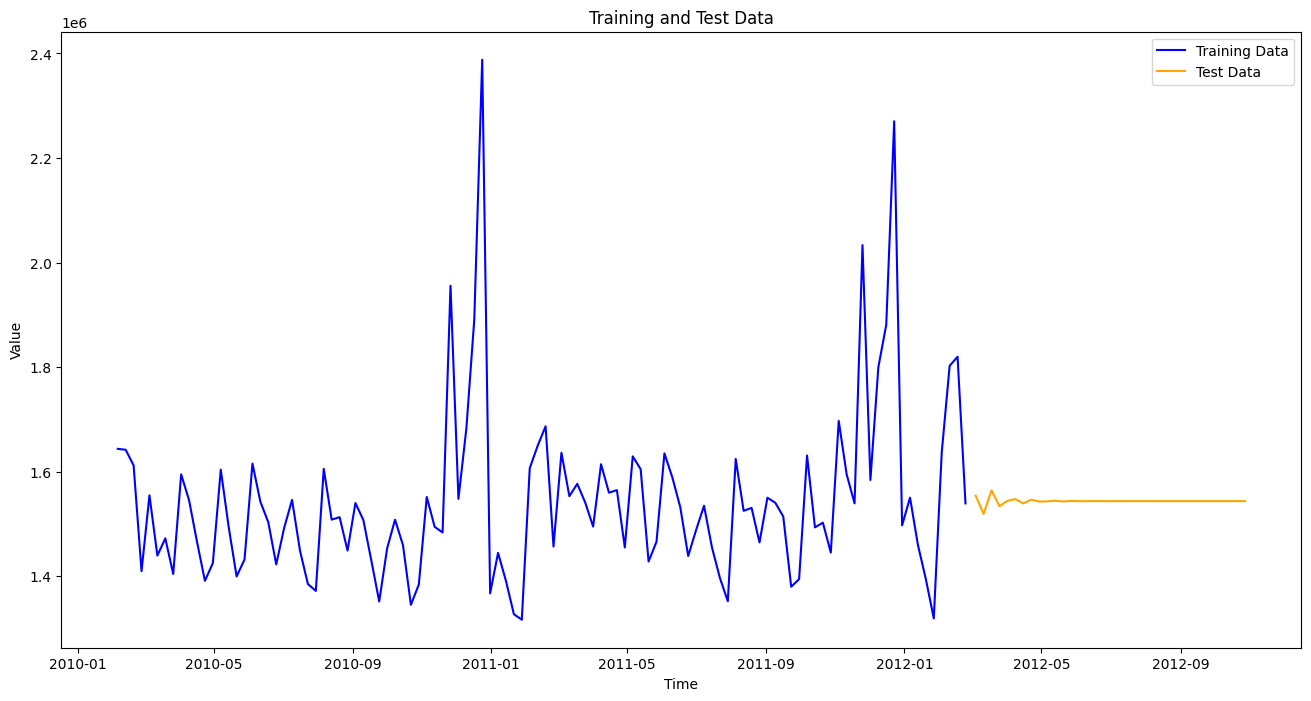

In [44]:
# Fit an AR(2,0,2) model
ARIMA_2_0_2 = ARIMA(endog = train_values, 
                    dates = train_dates, 
                    order = (2,0,2)).fit()

# Generate predictions
ARIMA_2_0_2_pred = ARIMA_2_0_2.predict(start=108, end = 142)


preds = pd.DataFrame(ARIMA_2_0_2_pred, index=date_list, columns = ['Weekly Sales'])

# Plot ARMA(2,0,2) model predictions
train_test_plot(train, preds)


In [45]:
# Evaluate our model on the training and testing sets
print(f'Training MSE: {mean_squared_error(train_values, ARIMA_2_0_2.predict())}')
print(f'Testing MSE: {mean_squared_error(test_values, ARIMA_2_0_2_pred)}')


Training MSE: 21403410708.952328
Testing MSE: 11379292741.273352


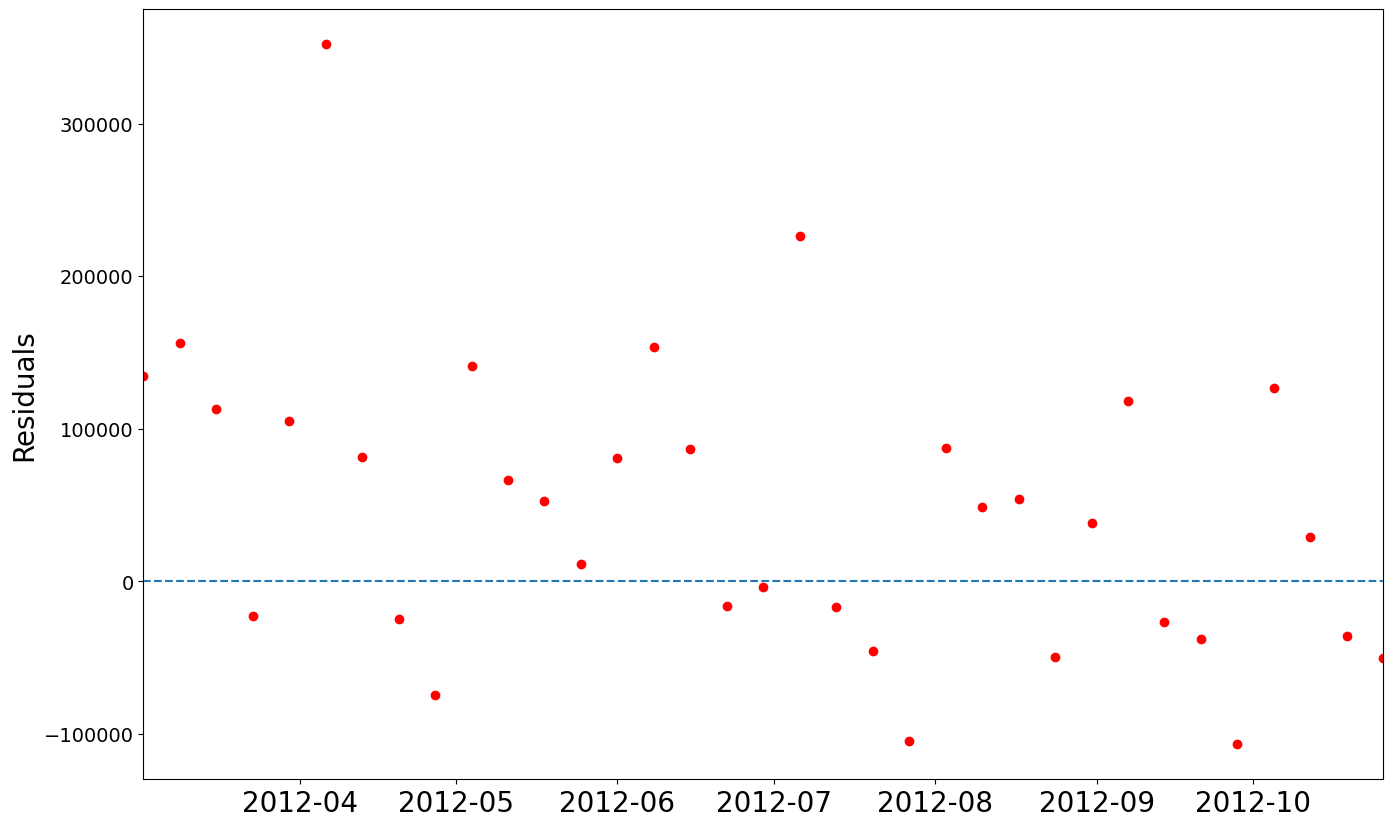

In [46]:
# Set figure size
plt.figure(figsize=(16,10))

# Calculate residuals.
resids = test['Weekly_Sales'].values - preds['Weekly Sales'].values

# Generate scatterplot of residuals.
plt.scatter(test['Weekly_Sales'].index, resids, c ='red')

# Plot baseline at y=0.
plt.hlines(y = 0,
           xmin = test['Weekly_Sales'].index.min(),
           xmax = test['Weekly_Sales'].index.max(),
           linestyles = '--')

# Set labels and axes.
plt.xticks(fontsize=20)
plt.xlim(test['Weekly_Sales'].index.min(), test['Weekly_Sales'].index.max())
plt.yticks(fontsize=14)
plt.ylabel('Residuals', fontsize = 20);

**6b. Interpret the results from the last answer.**


Same as for an ARIMA(2,0,2) model, since it is!

#### 7. Rolling Predictions

**Try testing the performance of your model using rolling predictions. For each testing observation $Y_t$ you should train your model using data up to $Y_{t-1}$. This allows us to make meaningful predictions for all testing observations** 

In [47]:
# Helper function to get the first week of each month in a given date list
def get_first_weeks(date_list):
    """
    Get the first week of each month in the given date list.
    
    Parameters:
        date_list (list): A list of datetime.date or datetime.datetime objects.
        
    Returns:
        list: A list containing the first day of each month.
    """
    firstweeks = []  # Initialize a list to store the first week dates
    
    # Iterate through the date list
    for position, date in enumerate(date_list):
        if position > 0:
            # Check if the month of the current date is different from the previous date
            if str(date)[5:7] != str(date_list[position - 1])[5:7]:
                firstweeks.append(date)  # Append the current date to the firstweeks list
                
    return firstweeks


The Mean Squared Error is: 11029530395.759796
The Root Mean Squared Error is: 105021.5710973693


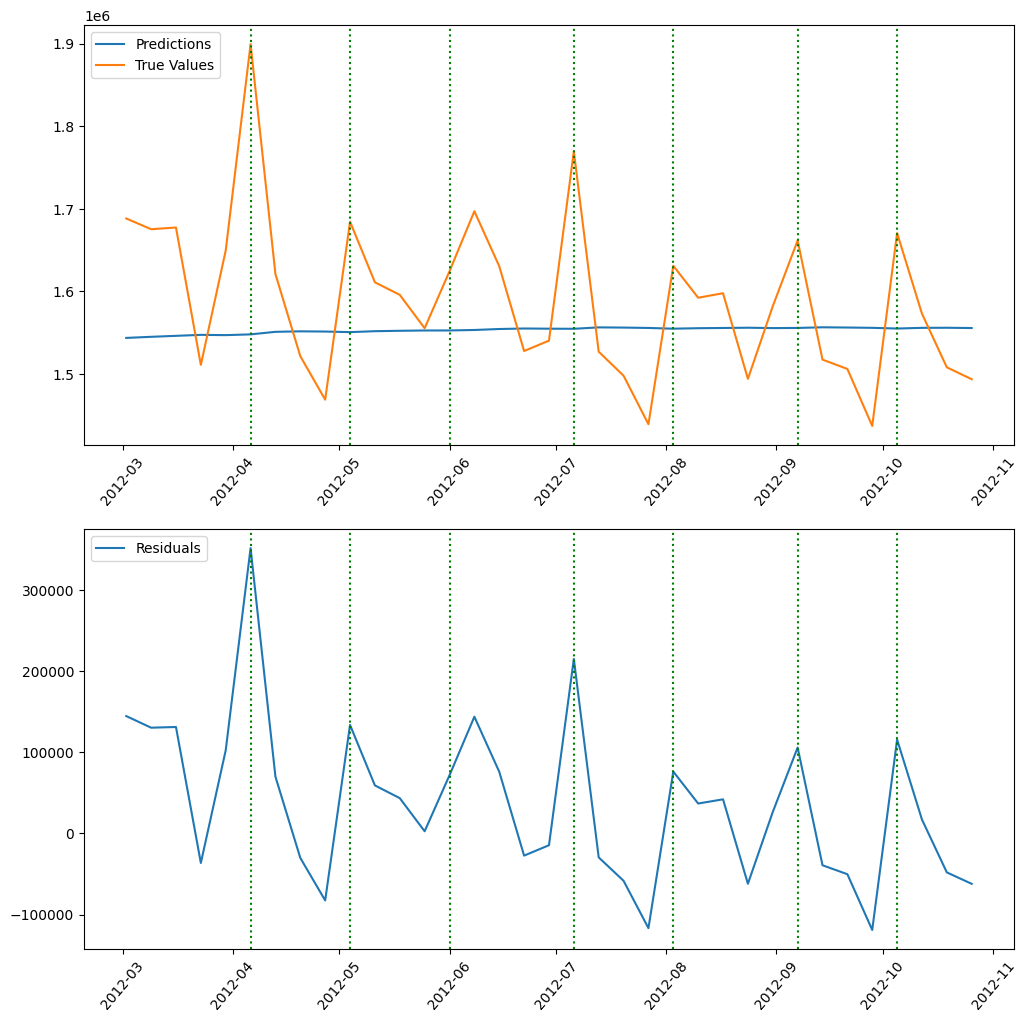

In [48]:
# Rolling predictions for AR(2) model 

# Initialize a list to store rolling predictions
predictions_rolling = []

# Prepare training and testing observations
training_observations = list(train['Weekly_Sales'].values)
testing_observations = test['Weekly_Sales'].values

# Iterate through each testing observation
for obs in testing_observations:
    # Fit an ARIMA model on the training observations
    model_roll = ARIMA(training_observations, order=(2, 0, 0)).fit()
    
    # Make a rolling prediction and append it to predictions_rolling
    predictions_rolling.append(model_roll.predict()[0])
    
    # Add the current testing observation to the training set for the next iteration
    training_observations.append(obs)
    
# Calculate the Mean Squared Error (MSE) between true values and rolling predictions
MSE = mean_squared_error(test['Weekly_Sales'], predictions_rolling)

# Print the calculated Mean Squared Error
print("The Mean Squared Error is:", MSE)
# Print the calculated Root Mean Squared Error
print("The Root Mean Squared Error is:", MSE** 0.5)

# Calculate residuals by subtracting rolling predictions from true values
residuals = test['Weekly_Sales'] - predictions_rolling

# Create a 2x1 subplot figure
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Customize tick rotation for better readability
ax1.tick_params('x', rotation=50)

# Plot rolling predictions and true values in the first subplot
ax1.plot(test.index, predictions_rolling, label='Predictions')
ax1.plot(test.index, testing_observations, label='True Values')

# Add vertical lines to mark the first week of each month
for xc in get_first_weeks(list(test.index)):
    ax1.axvline(x=xc, color='g', linestyle=':')

# Add legend to the first subplot
ax1.legend()

# Customize tick rotation for better readability
ax2.tick_params('x', rotation=50)

# Plot residuals in the second subplot
ax2.plot(test.index, residuals, label="Residuals")

# Add vertical lines to mark the first week of each month
for xc in get_first_weeks(list(test.index)):
    ax2.axvline(x=xc, color='g', linestyle=':')

# Add legend to the second subplot
ax2.legend();


My predictions are still a straight line! It seems only with SARIMA and a seasonality of 52 weeks then do the prediction start to mimic the shape of the actual test values